# Supporting Information

This notebook describes the full procedure in details, including all the preprocessing of the data. It is supplied as supporting information in order to make the results fully reproducible and allow parameters to be easily fitted again on other datasets.

Full data are available at the following git repository: https://github.com/bussilab/shape-dca-data

Required modules are available on conda with the command:

```
conda install -c conda-forge numpy pandas matplotlib sklearn xlrd
conda install -c bioconda viennarna
```

## Data Extraction

In this section we report the procedure required to build a pandas dataFrame containing all the available data.
The resulting pandas dataFrame is also provided in the file `data.p`.
The data-loading procedure can be skipped by directly loading `data.p` into the pandas dataFrame `data`:

`data = pd.read_pickle('data.p')`

In [1]:
## Import useful Python modules
import numpy as np
import pandas as pd
import subprocess as sp
import matplotlib.pyplot as plt
import os
import sklearn
import xlrd # used to import xls files
import RNA as rna # python interface to ViennaRNA

In the dataFrame we are going to build up, we will have, for each molecule: code-name of the reference PDB file (`pdb`), sequence (`seq_pdb`) and secondary structure (`stru`) extracted from the PDB file; sequence used in the SHAPE experiment (`seq_rdat`), raw reads (`r1` for the control channel and `r2` for the reaction one), SHAPE reactivities (`react`) reported in the rdat files if RMDB is the source of the SHAPE data (specified in `source`) and, if present, reference paper (`ref`); DCA score matrix (`dca`).

SHAPE data reported in the paper for the first time, measured in Sattler's Lab, are found in the excel sheet `shape_new.xlsx`. The corresponding PDBs are:

$\texttt{1KXK}\\ \texttt{2GIS}\\ \texttt{3IRW}\\ \texttt{3SD3}\\ \texttt{3VRS}$

More SHAPE data are taken from the RMDB database (.rdat files):


$\texttt{1EHZ}\quad \texttt{TRNAPH_1M7_0000.rdat}\\ \texttt{1Y26}\quad\texttt{ADDRSW_1M7_0001.rdat}\\ \texttt{2GDI}\quad\texttt{TPPRSW_1M7_0001.rdat}\\ \texttt{4YBB}\quad\texttt{5SRRNA_1M7_0001.rdat}$

For the rest of the molecules ($\texttt{3DIG}$ and $\texttt{3PDR}$) SHAPE data are taken from 10.1073/pnas.1219988110.

In [4]:
## skip data extraction
data = pd.read_pickle('data.p')

In [2]:
## Build up a Pandas dataframe including, for each molecule: code-name of the reference PDB file ('pdb'), 
## sequence ('seq_pdb') and secondary structure ('stru') extracted from the PDB file; 
## sequence used in the SHAPE experiment ('seq_rdat'), raw reads 
## ('r1' for the control channel and 'r2' for the reaction one), SHAPE reactivities ('react') reported in the 
## rdat files if RMDB is the source of the SHAPE data (specified in 'source') and, if present, reference 
## paper ('ref'); DCA score matrix ('dca').

## Notice: DCA score matrices will be added after subsection 'Shifts and Alignments'

data=pd.DataFrame(columns=['pdb','seq_pdb','stru','seq_rdat','r1','r2','react','source','ref','dca'])

## Unpublished SHAPE data
newdata_sheet=pd.ExcelFile('shape_new.xlsx').sheet_names
##
molecules = ['1EHZ','1KXK','1Y26','2GDI','2GIS','3DIG','3IRW','3PDR','3SD3','3VRS','4YBB_CB']
for mol in molecules:
    seq=stru=r1=r2=seq_rdat=seq_pdb=dca=None
    isdbn = False
    isrdat = False
    issheet = False
    for file in next(os.walk('./data/'+mol+'/'))[2]:
        print(file)
        if 'dbn' in file:
            isdbn = True
            dbnfile = file
        if 'rdat' in file:
            isrdat = True
            rdatfile = file
#             break
    if mol in newdata_sheet:
        issheet=True
    if isdbn:
        f = open('./data/'+mol+'/'+dbnfile,'r')
        g = f.readlines()
        seq_pdb = g[1][:-1]
        stru = g[2][:-1]
    if isrdat:
        seq_rdat = sp.check_output('grep SEQUENCE ./data/'+mol+'/'+rdatfile, shell=True).decode().split('\t')[1][:-1]
        if seq_pdb != seq_rdat:
            print(mol, 'Warning: sequences in pdb and rdat files not matching')
        r1 = np.array(sp.check_output('grep READS:1 ./data/'+mol+'/'+rdatfile+' | awk \'{for(i=2;i<=NF;i++) print $i}\'', shell=True).decode().split('\n')[:-1],dtype=float)
        r2 = np.array(sp.check_output('grep READS:2 ./data/'+mol+'/'+rdatfile+' | awk \'{for(i=2;i<=NF;i++) print $i}\'', shell=True).decode().split('\n')[:-1],dtype=float)
        react = np.array(sp.check_output('grep REACTIVITY 1: ./data/'+mol+'/'+rdatfile+' | awk \'{for(i=2;i<=NF;i++) print $i}\'', shell=True).decode().split('\n')[:-1],dtype=float)
        ref = sp.check_output('grep doi ./data/'+mol+'/'+rdatfile+' | tail -1 |awk \'{print $NF}\'',shell=True).decode().split('\n')[:-1][0]
        source = 'rmdb'
    if issheet:
        newdata = pd.read_excel('shape_new.xlsx',mol,header=2)
        seq_rdat = ''.join(np.array(newdata.nucleotide.values,dtype=str))
        r1 = newdata.areaRX.values
        r2 = newdata.areaBG.values
        source = 'Sattler\'s Lab'
        ref = 'unpublished'
        if seq_pdb != seq_rdat:
            print(mol, 'Warning: sequences in pdb and rdat files not matching')
    if not isdbn:
        print('Warning: no dbn file for '+mol)
    if not isrdat:
        print('Warning: no RMDB file for '+mol)
    if not issheet:
        print('Warning: not new data '+mol)
    data = data.append({'pdb': mol,'seq_pdb': seq_pdb, 'stru': stru, 'seq_rdat': seq_rdat, 'r1': r1,'r2': r2, 'react': react, 'source': source, 'ref': ref, 'dca': dca},ignore_index = True)
data.at[data[data.pdb=='3DIG'].index.values[0],'source']='Weeks\' Lab'
data.at[data[data.pdb=='3DIG'].index.values[0],'ref']='10.1073/pnas.1219988110'
data.at[data[data.pdb=='3PDR'].index.values[0],'source']='Weeks\' Lab'
data.at[data[data.pdb=='3PDR'].index.values[0],'ref']='10.1073/pnas.1219988110'

1EHZ.clu
1EHZ.dbn
1EHZ.shape
1EHZ.pdb
TRNAPH_1M7_0000.rdat
1EHZ Warning: sequences in pdb and rdat files not matching
1KXK.dbn
1KXK.pdb
1KXK Warning: sequences in pdb and rdat files not matching
1Y26.pdb
1Y26.shape
1Y26.dbn
1Y26.clu
ADDRSW_1M7_0001.rdat
1Y26 Warning: sequences in pdb and rdat files not matching
2GDI.pdb
2GDI.shape
TPPRSW_1M7_0001.rdat
2GDI.clu
2GDI.dbn
2GDI Warning: sequences in pdb and rdat files not matching
2GIS.dbn
2GIS.pdb
2GIS Warning: sequences in pdb and rdat files not matching
3DIG.shape
3DIG.pdb
3DIG.clu
3DIG.dbn
3IRW.pdb
3IRW.dbn
3IRW Warning: sequences in pdb and rdat files not matching
3PDR.clu
3PDR.dbn
3PDR.shape
3PDR.pdb
3SD3.dbn
3SD3.pdb
3SD3 Warning: sequences in pdb and rdat files not matching
3VRS.pdb
3VRS.dbn
3VRS Warning: sequences in pdb and rdat files not matching
4YBB_CB.dbn
5SRRNA_1M7_0001.rdat
4YBB_CB.clu
4YBB.cif
4YBB_CB.shape
4YBB_CB Warning: sequences in pdb and rdat files not matching


### Shifts and Alignments

SHAPE datasets require manual curation since sequences are sometime not identical to the one reported in the PDB and should be thus shifted accordingly. The following cell provides comments on all the included systems.

In [3]:
## Hereafter data are shifted according to comments in the RMDB and PDB files and 'seq_rdat'
## entry is used to contain the adjusted sequence.

## 1EHZ: 
#- PDB: all residues in the pdb are resolved
#- RMDB: The first nucleobase ('G') in the sequence from .rdat file is not present in PDB file
data.at[data[data.pdb=='1EHZ'].index.values[0], 'seq_rdat'] = data[data.pdb=='1EHZ'].seq_rdat.values[0][1:]
data.at[data[data.pdb=='1EHZ'].index.values[0], 'r1']       = data[data.pdb=='1EHZ'].r1.values[0][1:-1]
data.at[data[data.pdb=='1EHZ'].index.values[0], 'r2']       = data[data.pdb=='1EHZ'].r2.values[0][1:-1]

##1KXK
#-PDB: all residues in the pdb are resolved
# SHAPE: the last four reads are not assigned to nucleobases in the sequence. We thus discard the last three
# reads and assing the last one to the last nucleobase 'C' in the PDB sequence. Due to uncertainties in the
# assignment we perform a preliminary analysis that indicates a downward shift in read profile. 
data.at[data[data.pdb=='1KXK'].index.values[0], 'seq_rdat'] = data[data.pdb=='1KXK'].seq_rdat.values[0][:-12]+'C'
data.at[data[data.pdb=='1KXK'].index.values[0], 'r1']       = data[data.pdb=='1KXK'].r1.values[0][:-3]
data.at[data[data.pdb=='1KXK'].index.values[0], 'r2']       = data[data.pdb=='1KXK'].r2.values[0][:-3]
##shifts computed
data.at[data[data.pdb=='1KXK'].index.values[0], 'r1']       = np.append(np.zeros(1),data[data.pdb=='1KXK'].r1.values[0][:-1])
data.at[data[data.pdb=='1KXK'].index.values[0], 'r2']       = np.append(np.zeros(1),data[data.pdb=='1KXK'].r2.values[0][:-1])

##1Y26:
#-PDB: all residues in the pdb are resolved
#-RMDB: The first 3 nucleobases ('GGA') in the sequence from .rdat file are not present in PDB file
data.at[data[data.pdb=='1Y26'].index.values[0], 'seq_rdat'] = data[data.pdb=='1Y26'].seq_rdat.values[0][3:]
data.at[data[data.pdb=='1Y26'].index.values[0], 'r1']       = data[data.pdb=='1Y26'].r1.values[0][3:-1]
data.at[data[data.pdb=='1Y26'].index.values[0], 'r2']       = data[data.pdb=='1Y26'].r2.values[0][3:-1]

##2GDI:
#-PDB: all residues in the pdb are resolved
#-RMDB: The first ('G') and last ('C') nucleobases in the sequence from .rdat file are not present in PDB file
#-RMDB: The RNA transcript is preceded by a 'GG' sequence
data.at[data[data.pdb=='2GDI'].index.values[0], 'seq_rdat'] = data[data.pdb=='2GDI'].seq_rdat.values[0][1:-1]
data.at[data[data.pdb=='2GDI'].index.values[0], 'r1']       = data[data.pdb=='2GDI'].r1.values[0][2:]
data.at[data[data.pdb=='2GDI'].index.values[0], 'r2']       = data[data.pdb=='2GDI'].r2.values[0][2:]

#2GIS:
#-PDB: all residues in the pdb are resolved
#-SHAPE experiment: first 6 nucleobases and last 4 nucleobases: reads not measured, we replace them with the average
# of reads profile for both channels.
data.at[data[data.pdb=='2GIS'].index.values[0], 'seq_rdat'] = 'GGCUUA'+data[data.pdb=='2GIS'].seq_rdat.values[0]+'GCCA'
mr1 = np.mean(data[data.pdb=='2GIS'].r1.values[0])
mr2 = np.mean(data[data.pdb=='2GIS'].r2.values[0])
data.at[data[data.pdb=='2GIS'].index.values[0], 'r1'] = np.append(mr1*np.ones(6),data[data.pdb=='2GIS'].r1.values[0])
data.at[data[data.pdb=='2GIS'].index.values[0], 'r2'] = np.append(mr2*np.ones(6),data[data.pdb=='2GIS'].r2.values[0])
data.at[data[data.pdb=='2GIS'].index.values[0], 'r1'] = np.append(data[data.pdb=='2GIS'].r1.values[0],mr1*np.ones(4))
data.at[data[data.pdb=='2GIS'].index.values[0], 'r2'] = np.append(data[data.pdb=='2GIS'].r2.values[0],mr2*np.ones(4))

#3DIG:
#-PDB: all residues in the pdb are resolved but last one is a CCC (CYTIDINE-5'-PHOSPHATE-2',3'-CYCLIC PHOSPHATE) bound to first G.
data.at[data[data.pdb=='3DIG'].index.values[0], 'seq_rdat'] = data[data.pdb=='3DIG'].seq_pdb.values[0]

##3IRW:
#-PDB: last residue of the sequence from PDB file is not included because it is not resolved
#-SHAPE: the first nucleobase 'G' is missing. Due to uncertainties in the assignment we perform 
# a preliminary analysis that indicates a downward shift of two reads in read profile.
data.at[data[data.pdb=='3IRW'].index.values[0], 'seq_rdat'] =  'G'+data.at[data[data.pdb=='3IRW'].index.values[0], 'seq_rdat'][:-1]
##shifts computed
data.at[data[data.pdb=='3IRW'].index.values[0], 'r1'] = np.append(np.zeros(2),data[data.pdb=='3IRW'].r1.values[0][:-2])
data.at[data[data.pdb=='3IRW'].index.values[0], 'r2'] = np.append(np.zeros(2),data[data.pdb=='3IRW'].r2.values[0][:-2])
data.at[data[data.pdb=='3IRW'].index.values[0], 'stru'] = data[data.pdb=='3IRW'].stru.values[0][:-1]

##3PDR:
#-PDB: all residues in the pdb are resolved
#-SHAPE: The first ('GGG') and last ('CCCA') parts of the sequence reporte in SHAPE data files is not present
#in the sequence from PDB file. They are included with additive effect on the structure extracted from the PDB. 
data.at[data[data.pdb=='3PDR'].index.values[0], 'seq_rdat'] = 'GGG'+data[data.pdb=='3PDR'].seq_pdb.values[0]+'CCCA'
data.at[data[data.pdb=='3PDR'].index.values[0], 'stru'] = '((('+data[data.pdb=='3PDR'].stru.values[0]+'))).'

##3SD3:
#-PDB: all residues in the pdb are resolved
#-SHAPE: The first 9 nucleobases of the sequence in the pdb are not assigned a read in the experiment: 
# we insert the mean of the rest of the read profile at their places. Due to uncertainties in the assignment 
# we perform a preliminary analysis that indicates an upward shift of two reads in read profile.
data.at[data[data.pdb=='3SD3'].index.values[0], 'seq_rdat'] = data[data.pdb=='3SD3'].seq_pdb.values[0]
mr1 = np.mean(data[data.pdb=='3SD3'].r1.values[0])
mr2 = np.mean(data[data.pdb=='3SD3'].r2.values[0])
data.at[data[data.pdb=='3SD3'].index.values[0], 'r1'] = np.append(mr1*np.ones(9),data[data.pdb=='3SD3'].r1.values[0])
data.at[data[data.pdb=='3SD3'].index.values[0], 'r2'] = np.append(mr2*np.ones(9),data[data.pdb=='3SD3'].r2.values[0])
data.at[data[data.pdb=='3SD3'].index.values[0], 'r1'] = np.append(data[data.pdb=='3SD3'].r1.values[0],mr1*np.ones(2))
data.at[data[data.pdb=='3SD3'].index.values[0], 'r2'] = np.append(data[data.pdb=='3SD3'].r2.values[0],mr2*np.ones(2))
##shifts computed
data.at[data[data.pdb=='3SD3'].index.values[0], 'r1']       = np.append(data[data.pdb=='3SD3'].r1.values[0][2:],np.zeros(2))
data.at[data[data.pdb=='3SD3'].index.values[0], 'r2']       = np.append(data[data.pdb=='3SD3'].r2.values[0][2:],np.zeros(2))


##3VRS
#-PDB: all residues in the pdb are resolved
# SHAPE: The last part of 'seq_rdat' is 'nan': we remove the last three letters.
# The first part 'GGGC' of the sequence is missing in the sequence: we insert the 
# mean of the rest of the read profile at their places. Due to uncertainties in the assignment 
# we perform a preliminary analysis that indicates a downward shift of 4 reads in read profile.
data.at[data[data.pdb=='3VRS'].index.values[0], 'seq_rdat'] = data[data.pdb=='3VRS'].seq_rdat.values[0][:-3]
data.at[data[data.pdb=='3VRS'].index.values[0], 'seq_rdat'] = 'GGGC'+data[data.pdb=='3VRS'].seq_rdat.values[0]
mr1 = np.mean(data[data.pdb=='3VRS'].r1.values[0][:-1])
mr2 = np.mean(data[data.pdb=='3VRS'].r2.values[0][:-1])
data.at[data[data.pdb=='3VRS'].index.values[0], 'r1'] = np.append(mr1*np.ones(4),data[data.pdb=='3VRS'].r1.values[0][:-1])
data.at[data[data.pdb=='3VRS'].index.values[0], 'r2'] = np.append(mr2*np.ones(4),data[data.pdb=='3VRS'].r2.values[0][:-1])

##4YCB_CB
#-PDB: all residues in the pdb are resolved
#-RMDB: The first 3 nucleobases ('GGA') in the sequence from .rdat file are not present in PDB file. 
# Due to uncertainties in the assignment we perform a preliminary analysis that indicates
# an upward shift of 1 read in read profile.
data.at[data[data.pdb=='4YBB_CB'].index.values[0], 'seq_rdat'] = data[data.pdb=='4YBB_CB'].seq_rdat.values[0][3:]
data.at[data[data.pdb=='4YBB_CB'].index.values[0], 'r1']       = data[data.pdb=='4YBB_CB'].r1.values[0][3:-1]
data.at[data[data.pdb=='4YBB_CB'].index.values[0], 'r2']       = data[data.pdb=='4YBB_CB'].r2.values[0][3:-1]
##shifts computed
data.at[data[data.pdb=='4YBB_CB'].index.values[0], 'r1']       = np.append(data[data.pdb=='4YBB_CB'].r1.values[0][1:],np.zeros(1))
data.at[data[data.pdb=='4YBB_CB'].index.values[0], 'r2']       = np.append(data[data.pdb=='4YBB_CB'].r2.values[0][1:],np.zeros(1))

In [4]:
## Replace all sequence entries with the aligned one 
data = data.drop(columns=['seq_pdb'])
data = data.rename(columns={"seq_rdat": "seq"})

### DCA score matrix

DCA score matrix are here read. They were originally generated from multiple sequence alignments using the ClustalW alignment software and the Boltzmann learning DCA implemented here: https://github.com/bussilab/bl-dca. In particular, the score matrices can be generated with the following commands:

##### Example for 1EHZ.

To align multiple sequences we use ClustalW:
```
./clustalo -i RF00005.fa -o MSA.clu --outfmt=clu  
```
Then we run the scripts from  https://github.com/bussilab/bl-dca. 

The first script generates a file called `seqs` using multiple parllelized processors. The number of processors must be specified.
```
./run.sh MSA.clu <number_of_processors>
```

Next the Boltzmann learning DCA code must be run in the following way:
```
mpirun -np <number_of_processors> dca.o
```

The DCA scores are output to a file named `scores`. In order to let it be read into the dataset, move it to the right directory (see next cell).
```
mv scores ./data/dca_scores/scores_1EHZ
```
Here is the list of RFAM files included for the systems in the dataset:
```
1EHZ     RF00005.fa
1KXK     RF00029.fa
1Y26     RF00167.fa
2GDI     RF00059.fa
2GIS     RF00162.fa
3DIG     RF00168.fa
3IRW     RF01051.fa
3PDR     RF00380.fa
3SD3     RF01831.fa
3VRS     RF01734.fa
4YBB_CB  RF00001.fa
```

In [5]:
## Import DCA scores
for mol in data.pdb.values:
    file = './data/dca_scores/scores_'+mol
    if os.path.isfile(file):
        seq = data[data.pdb==mol].seq.values[0]
        dca = np.zeros((len(seq),len(seq)))
        with open(file,'r') as fin:
            for line in fin.readlines():
                i=int(line.split()[1])
                j=int(line.split()[2])
                dca[i,j]=float(line.split()[0])
        data.at[data[data.pdb==mol].index.values[0],'dca']=dca
    else:
        print('Error: no DCA file')

In [6]:
data

,pdb,stru,seq,r1,r2,react,source,ref,dca
0,1EHZ,(((((((..((((.....[..)))).((((.........))))......,GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...,"[1941.0, 368.0, 151.0, 235.0, 5019.0, 1516.0, ...","[277.0, 104.0, 85.0, 100.0, 537.0, 271.0, 147....","[4.4006, 0.2557, 0.0, 0.0, 10.9165, 1.842, 0.7...",rmdb,10.1093/nar/gku909.,"[[0.0, 0.111653, 0.227203, 0.0106943, 0.066061..."
1,1KXK,.....(((..(((((...(((((((((((((((....)))))..))...,GUCUACCUAUCGGGCUAAGGAGCCGUAUGCGAUGAAAGUCGCACGU...,"[0.0, 5757.07, 8084.96, 1349.31, 1728.15, 7404...","[0.0, 6943.0, 8570.87, 2127.98, 2876.36, 9562....","[4.4006, 0.2557, 0.0, 0.0, 10.9165, 1.842, 0.7...",Sattler's Lab,unpublished,"[[0.0, 0.00657873, 0.00717814, 0.00151821, 0.0..."
2,1Y26,((((((((((..((((((......[[.))))))[.....)](((((...,CGCUUCAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGA...,"[5508.0, 3318.0, 370.0, 503.0, 3695.0, 496.0, ...","[7714.0, 10507.0, 2221.0, 3077.0, 27306.0, 265...","[10.2056, 26.3932, 4.2661, 0.4241, 0.0, 0.0, 0...",rmdb,10.1093/nar/gku909.,"[[0.0, 0.103944, 0.20016, 0.0459288, 0.0511341..."
3,2GDI,((((((((.((((.(((.[[..))))))......)..))))........,GACUCGGGGUGCCCUUCUGCGUGAAGGCUGAGAAAUACCCGUAUCA...,"[2541.0, 583.0, 2645.0, 558.0, 273.0, 176.0, 1...","[4315.0, 835.0, 3149.0, 681.0, 370.0, 280.0, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rmdb,10.1093/nar/gku909.,"[[0.0, 0.399929, 0.0035304, 0.226381, 0.298004..."
4,2GIS,((((((((....(.(((...(((.[.[[)))......))))(((.....,GGCUUAUCAAGAGAGGUGGAGGGACUGGCCCGAUGAAACCCGGCAA...,"[2063.1529761904762, 2063.1529761904762, 2063....","[1045.2678571428573, 1045.2678571428573, 1045....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sattler's Lab,unpublished,"[[0.0, 0.42395, 0.25059, 0.0770838, -0.154762,..."
5,3DIG,(((((((((..(.((((((..(.......(((((((((..(..[[[...,GGCCGACGGAGGCGCGCCCGAGAUGAGUAGGCUGUCCCAUCAGGGG...,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Weeks' Lab,10.1073/pnas.1219988110,"[[0.0, 0.18623, 0.0610614, 0.0608257, 0.039369..."
6,3IRW,..((((......((...((((((....))))))..[))...(((.(...,GUCACGCACAGGGCAAACCAUUCGAAAGAGUGGGACGCAAAGCCUC...,"[0.0, 0.0, 32698.75, 106310.3, 20898.57, 38978...","[0.0, 0.0, 22531.88, 3897.57, 5761.29, 52051.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sattler's Lab,unpublished,"[[0.0, -0.0475488, -0.0452709, 0.151875, 0.011..."
7,3PDR,((((((((([.(((..(((..((((((((......(((((((((((...,GGGCUUCGUUAGGUGAGGCUCCUGUAUGGAGAUACGCUGCUGCCCA...,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Weeks' Lab,10.1073/pnas.1219988110,"[[0.0, 0.114332, 0.313041, 0.156669, 0.037561,..."
8,3SD3,((((....((((((((((((......(((((((...[[[[[...))...,GGAGAGUAGAUGAUUCGCGUUAAGCGUGUGUGAAUGGGAUGUCGUC...,"[3308.593846153846, 3308.593846153846, 3308.59...","[2768.019102564103, 2768.019102564103, 2768.01...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sattler's Lab,unpublished,"[[0.0, 0.0753498, 0.00693142, 0.24431, -0.0212..."
9,3VRS,.[[[[..((((((]]]]......(((((....)))))....)))))...,GGGCGAUGAGGCCCGCCCAAACUGCCCUGAAAAGGGCUGAUGGCCU...,"[22047.625416666666, 22047.625416666666, 22047...","[24998.380624999994, 24998.380624999994, 24998...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sattler's Lab,unpublished,"[[0.0, 0.13909, -0.0761913, -0.0980433, -0.070..."


### Estimate SHAPE reactivities

If raw reads are not available, but SHAPE reactivities are, we normalize a reactivity profile by subtracting its mean from it. In case of missing values, typically indicated by a value of -999.0, we replace them with the mean of the profile.

If raw reads are available, we process them into SHAPE reactivities in the following way:
1. Reads in the control channel $r^{(1)}$ are divided by their sum
\begin{equation}
R^{(1)}_i = \frac{r^{(1)}_i}{\sum\limits_{j=1}^{l_{seq}}r^{(1)}_j}
\end{equation}
2. Reads in the reaction channel $r^{(2)}$ are divided by their sum
\begin{equation}
R^{(2)}_i = \frac{r^{(2)}_i}{\sum\limits_{j=1}^{l_{seq}}r^{(2)}_j}
\end{equation}
3. Normalized SHAPE reactivties are obtained by subtraction of the read profiles, with replacement of negative values with 0:
\begin{equation}\label{norm}
N_i = \max{\{0,\quad R^{(2)}_i-R^{(1)}_i\}}
\end{equation}

In [7]:
## Add a new column in our dataframe for normalized reactivties.
data['norm_r'] = None

In [8]:
## Apply the alternative normalization for available SHAPE data lacking the original raw reads.
for mol in ['3DIG', '3PDR']:
    rr = np.loadtxt('data/'+mol+'/'+mol+'.shape')
    ss = 0.0
    cc = 0.0
    for i in range(len(rr)):
        if rr[i] != -999.0:
            ss += rr[i]
            cc += 1
    for i in range(len(rr)):
        if rr[i] == -999.0:
            rr[i] = ss/cc
    data.at[data[data.pdb==mol].index.values[0],'norm_r'] = rr

In [9]:
## For molecule 3PDR, nucleobases missing from the PDB sequence are assigned a reactivity equal to the mean of
## the rest of reactivities.
mrr = np.mean(data[data.pdb==mol].norm_r.values[0])
data.at[data[data.pdb==mol].index.values[0], 'norm_r'] = np.append(mrr*np.ones(3),data[data.pdb==mol].norm_r.values[0])
data.at[data[data.pdb==mol].index.values[0], 'norm_r'] = np.append(data[data.pdb==mol].norm_r.values[0],mrr*np.ones(4))

In [10]:
## Define a function to compute and normalize reactivities from raw reads.
def compute_reactivities(r1,r2):
    norm_r=(r1/np.sum(r1)-r2/np.sum(r2))*len(r1)
    for i in range(len(norm_r)):
        if norm_r[i]<0.0: norm_r[i]=0.0
    return norm_r

In [11]:
## Apply the normalization function to raw reads.
for mol in data.pdb.values:
    r1=data[data.pdb==mol].r1.values[0]
    r2=data[data.pdb==mol].r2.values[0]
    if r1 is not None:
        data.at[data[data.pdb==mol].index.values[0], 'norm_r'] = compute_reactivities(r1,r2)

In [12]:
# Due to uncertainties in the assignment of reads to '3SD3' we perform a preliminary analysis that indicates
# an upward shift of 1 in the normalized reactivity profile.
mad = np.mean(data[data.pdb=='3SD3'].norm_r.values[0])
data.at[data[data.pdb=='3SD3'].index.values[0], 'norm_r'] = np.append(data[data.pdb=='3SD3'].norm_r.values[0][1:],np.ones(1)*mad)


As result of all the previous steps, we obtain the following dataset, that is the one used for all the training and validation procedures reported in the main text.



In [13]:
## This is the dataset used in our work
data

,pdb,stru,seq,r1,r2,react,source,ref,dca,norm_r
0,1EHZ,(((((((..((((.....[..)))).((((.........))))......,GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...,"[1941.0, 368.0, 151.0, 235.0, 5019.0, 1516.0, ...","[277.0, 104.0, 85.0, 100.0, 537.0, 271.0, 147....","[4.4006, 0.2557, 0.0, 0.0, 10.9165, 1.842, 0.7...",rmdb,10.1093/nar/gku909.,"[[0.0, 0.111653, 0.227203, 0.0106943, 0.066061...","[0.3455733162332359, 0.0, 0.0, 0.0, 1.97201034..."
1,1KXK,.....(((..(((((...(((((((((((((((....)))))..))...,GUCUACCUAUCGGGCUAAGGAGCCGUAUGCGAUGAAAGUCGCACGU...,"[0.0, 5757.07, 8084.96, 1349.31, 1728.15, 7404...","[0.0, 6943.0, 8570.87, 2127.98, 2876.36, 9562....","[4.4006, 0.2557, 0.0, 0.0, 10.9165, 1.842, 0.7...",Sattler's Lab,unpublished,"[[0.0, 0.00657873, 0.00717814, 0.00151821, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19253560..."
2,1Y26,((((((((((..((((((......[[.))))))[.....)](((((...,CGCUUCAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGA...,"[5508.0, 3318.0, 370.0, 503.0, 3695.0, 496.0, ...","[7714.0, 10507.0, 2221.0, 3077.0, 27306.0, 265...","[10.2056, 26.3932, 4.2661, 0.4241, 0.0, 0.0, 0...",rmdb,10.1093/nar/gku909.,"[[0.0, 0.103944, 0.20016, 0.0459288, 0.0511341...","[0.9850572836626584, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2GDI,((((((((.((((.(((.[[..))))))......)..))))........,GACUCGGGGUGCCCUUCUGCGUGAAGGCUGAGAAAUACCCGUAUCA...,"[2541.0, 583.0, 2645.0, 558.0, 273.0, 176.0, 1...","[4315.0, 835.0, 3149.0, 681.0, 370.0, 280.0, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rmdb,10.1093/nar/gku909.,"[[0.0, 0.399929, 0.0035304, 0.226381, 0.298004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2GIS,((((((((....(.(((...(((.[.[[)))......))))(((.....,GGCUUAUCAAGAGAGGUGGAGGGACUGGCCCGAUGAAACCCGGCAA...,"[2063.1529761904762, 2063.1529761904762, 2063....","[1045.2678571428573, 1045.2678571428573, 1045....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sattler's Lab,unpublished,"[[0.0, 0.42395, 0.25059, 0.0770838, -0.154762,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1921538295628..."
5,3DIG,(((((((((..(.((((((..(.......(((((((((..(..[[[...,GGCCGACGGAGGCGCGCCCGAGAUGAGUAGGCUGUCCCAUCAGGGG...,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Weeks' Lab,10.1073/pnas.1219988110,"[[0.0, 0.18623, 0.0610614, 0.0608257, 0.039369...","[0.117, 0.117, 0.117, 0.273, 0.117, 0.0, 0.156..."
6,3IRW,..((((......((...((((((....))))))..[))...(((.(...,GUCACGCACAGGGCAAACCAUUCGAAAGAGUGGGACGCAAAGCCUC...,"[0.0, 0.0, 32698.75, 106310.3, 20898.57, 38978...","[0.0, 0.0, 22531.88, 3897.57, 5761.29, 52051.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sattler's Lab,unpublished,"[[0.0, -0.0475488, -0.0452709, 0.151875, 0.011...","[0.0, 0.0, 0.0, 3.103932690115823, 0.386158613..."
7,3PDR,((((((((([.(((..(((..((((((((......(((((((((((...,GGGCUUCGUUAGGUGAGGCUCCUGUAUGGAGAUACGCUGCUGCCCA...,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Weeks' Lab,10.1073/pnas.1219988110,"[[0.0, 0.114332, 0.313041, 0.156669, 0.037561,...","[0.6013333333333334, 0.6013333333333334, 0.601..."
8,3SD3,((((....((((((((((((......(((((((...[[[[[...))...,GGAGAGUAGAUGAUUCGCGUUAAGCGUGUGUGAAUGGGAUGUCGUC...,"[3308.593846153846, 3308.593846153846, 3308.59...","[2768.019102564103, 2768.019102564103, 2768.01...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sattler's Lab,unpublished,"[[0.0, 0.0753498, 0.00693142, 0.24431, -0.0212...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,3VRS,.[[[[..((((((]]]]......(((((....)))))....)))))...,GGGCGAUGAGGCCCGCCCAAACUGCCCUGAAAAGGGCUGAUGGCCU...,"[22047.625416666666, 22047.625416666666, 22047...","[24998.380624999994, 24998.380624999994, 24998...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Sattler's Lab,unpublished,"[[0.0, 0.13909, -0.0761913, -0.0980433, -0.070...","[0.0, 0.0, 0.0, 0.0, 1.5907027014388504, 0.0, ..."


The dataFrame built up until here can be saved to the `data.p` file with the next command. `data.p` is already present in the repository, but you may need to save a new one in case you modified or added data in the dataFrame.

In [14]:
if os.path.isfile('./data.p')==False:
    data.to_pickle('./data.p')

## Model optimization

Once the dataset is complete, models can be trained and tested.
In this repository, you will find a Pyhton script called 'model_optimize.py' that can be run to either train a model or to test it by the leave-one-out procedure reported in the main text.
The triplet of hyperparameters ($\alpha_S$ for the regularization of SHAPE penalties, $\alpha_D$ for that of DCA penalties and $p$ for the number of neighbouring reactivities to be included in the SHAPE penalties) that defines a model must be given as parameters to the script in the following order:
- $\color{red}{\texttt{\$as}} = \alpha_S$
- $\color{red}{\texttt{\$ad}} = \alpha_D$
- $\color{red}{\texttt{\$p}} = p$, 
- optimization phase (either `train` for training or `test` for leave-one-out).
- In case one is performing the leave-one-out test, also the index of molecule to be left out must be specified, through the variable $\color{red}{\texttt{\$leftout}}$.

Results that by default are saved to a text file include: pdb code, molecule index, cost function averaged on the training set, cost function for the specific system with ViennaRNA and with the trained model, MCC between the MFE structure and the native one, for each system, first with ViennaRNA and then with the trained model. These are saved to a file that must be specified thorugh the variable $\color{red}{\texttt{\$results_file}}$.
Optimized values of model parameters are saved to a file that must be specified thrugh the variable $\color{red}{\texttt{\$parameters_file}}$. Since multiple minimization are performed with different initial parameters, also the corresponding initial parameters are stored.

Here you find two examples on how to run the script:
- Training: 

$\texttt{python3 model_optimize.py}$ $\texttt{\$as}$ $\texttt{\$ad}$ $\texttt{\$p}$ train $\texttt{\$results_file}$ $\texttt{\$parameters-_file}$
- Leave-One-Out

$\texttt{python3 model_optimize.py}$ $\texttt{\$as}$ $\texttt{\$ad}$ $\texttt{\$p}$ test $\texttt{\$results_file}$ $\texttt{\$parameters-_file}$ $\texttt{\$leftout}$ 

Since optimal parameters of simpler and more strongly regularized models are intended to be passed as initial parameter values of more complex and less regularized models, as described in the main text, by default the script reads the output parameters of a precedent stage of the minimization from parameter files called $\texttt{ewregl\$\{as\}}$_ $\texttt{\$\{ad\}}$ _ $\texttt{\$\{p\}}$ _ $\texttt{\$\{mod\}}$ _ $\texttt{par.dat}$. Thus it is recommended to name the output parameters files in the same way. This can be changed easily by modifying the script. Consider that in order to find the parameter files the script assumes that the smallest regularization parameter larger than zero in the grid is 0.0001 and the largest regularization parameter smaller than infinity in the grid is 1.0. This can be changed editing the script as well. In the next section results will be extracted from output files named in the default way.

## Analysis of results

Here we collect results of model optimization for each system (identified by 'pdb'), each random splitting of the dataset (different values of 'seed'), and for each model (defined by 'alpha_s','alpha_d' and 'p'). The cost function
\begin{equation}
\mathcal{C}_0=-RT\ln P_0\left(\hat{s} | \vec{seq}\right)
\end{equation}
assigned to native structures $\hat{s}$ via unmodified ViennaRNA is indicated by 'vienna_cost', for comparison with that obtained with each trained model,
\begin{equation}
\mathcal{C}\left(\{a_k,b\}, \{A,B,C,D\}\right)=-RT\ln P\left(\hat{s} | \vec{seq}, \vec{R}, \vec{J}\right)
\end{equation}
called 'train_cost'. The cost function related to the native structure of each molecule, when that is the one left-out for transferability estimation, is indicated by 'test_cost'.
Dataset splittings reported in the main text as $\{S1,\dots,S5\}$ correspond to values of 'seed' $\{1995,\dots,1999\}$.

In order to decrease the size of this repository, we directly include a pandas dataset (`results.p`) that contains all the results. The script in the following cell reads the results from the output files produced as described above.

In [5]:
## We first make a hard copy of the dataset for possible modifications
dataset = data.copy()
from sklearn.model_selection import train_test_split ## method to generate random splittings of the dataset  
## We build up a Pandas DataFrame to collect results. The dataframe is already saved to the file 'results.p' in
## this repistory. In case you want to build up a new data frame with different results, just name it differently 
## from 'results' or either rename the file 'results.p'
results = pd.DataFrame(columns=['pdb','seed','p','alpha_s','alpha_d','vienna_cost','train_cost', 'test_cost'])
if os.path.isfile('./results.p')==False:
    alpha_s = [np.inf,1e0,1e-1,1e-2,1e-3,1e-4,0.0]
    alpha_d = alpha_s.copy()
    p = range(4)
    seed = [1995,1996,1997,1998,1999] ## these correspond to dataset splittings [S1,S2,S3,S4,S5]
    for sd in seed:
        train, test = train_test_split(dataset, test_size=0.2,random_state=sd)
        for ass in alpha_s:
            for add in alpha_d:
                for k in p:
                    file=str(sd)+'_slqs/ewregl'+str(ass)+'_'+str(add)+'_'+str(k)+'_test.dat'
                    trainset = np.array(train.pdb.values, dtype=str)
                    trainset.sort()
                    f=open(file,'r')
                    g=f.readlines()
                    f.close()
                    file=str(sd)+'_slqs/ewregl'+str(ass)+'_'+str(add)+'_'+str(k)+'_train.dat'
                    f=open(file,'r')
                    h=f.readlines()
                    for m,mol in enumerate(trainset):
                        results = results.append({'pdb': mol,'seed': sd, 'p': k,'alpha_s': ass,'alpha_d': add,'vienna_cost': float(g[m].split()[3]), 'train_cost': float(h[m].split()[4]),'test_cost': float(g[m].split()[4])},ignore_index=True)
                    f.close()
    results.to_pickle('./results.p')
else:
    results=pd.read_pickle('./results.p')

In [6]:
## Here we add average cost function in train and test for each model
seeds = [1995,1996,1997,1998,1999]
alpha_s = [np.inf,1e0,1e-1,1e-2,1e-3,1e-4,0.0]
alpha_d = alpha_s.copy()
p = range(4)
results['train_cost_average'] = 0.0
results['test_cost_average'] = 0.0
for seed in seeds:
    for ass in alpha_s:
        for add in alpha_d:
            for k in p:
                results.loc[(results.seed==seed) & (results.p==k) & (results.alpha_s==ass) & (results.alpha_d==add), 'train_cost_average']=results[(results.seed==seed) & (results.p==k) & (results.alpha_s==ass) & (results.alpha_d==add)].train_cost.values.mean()
                results.loc[ (results.seed==seed) & (results.p==k) & (results.alpha_s==ass) & (results.alpha_d==add), 'test_cost_average']=results[(results.seed==seed) & (results.p==k) & (results.alpha_s==ass) & (results.alpha_d==add)].test_cost.values.mean()

In [17]:
results

,pdb,seed,p,alpha_s,alpha_d,vienna_cost,train_cost,test_cost,train_cost_average,test_cost_average
0,1EHZ,1995,0,inf,inf,3.127302,3.127302,3.127302,6.400741,6.400741
1,1KXK,1995,0,inf,inf,7.256645,7.256645,7.256645,6.400741,6.400741
2,1Y26,1995,0,inf,inf,6.029465,6.029465,6.029465,6.400741,6.400741
3,2GDI,1995,0,inf,inf,2.712807,2.712807,2.712807,6.400741,6.400741
4,2GIS,1995,0,inf,inf,9.442827,9.442827,9.442827,6.400741,6.400741
5,3DIG,1995,0,inf,inf,8.347254,8.347254,8.347254,6.400741,6.400741
6,3IRW,1995,0,inf,inf,6.188628,6.188628,6.188628,6.400741,6.400741
7,4YBB_CB,1995,0,inf,inf,8.101004,8.101004,8.101004,6.400741,6.400741
8,1EHZ,1995,1,inf,inf,3.127302,3.127302,3.127302,6.400741,6.400741
9,1KXK,1995,1,inf,inf,7.256645,7.256645,7.256645,6.400741,6.400741


In [18]:
# We now build up a Pandas DataFrame containing all the optimized parameters 
# for each model and dataset splitting. For each model, parameters are split 
# into parameters of DCA nodes ('par_dca') and parameters of SHAPE nodes ('par_shape').
models_trained = pd.DataFrame(columns=['seed','p','alpha_s','alpha_d','par_dca','par_shape'])
alpha_s = [np.inf,1e0,1e-1,1e-2,1e-3,1e-4,0.0]
alpha_d = alpha_s.copy()
p = range(4)
seeds = [1995,1996,1997,1998,1999]
if os.path.isfile('./models_trained.p')==False:
    for seed in seeds:
        train, test = train_test_split(dataset, test_size=0.2,random_state=seed)
        for i in alpha_s:
            for j in alpha_d:
                for k in p:
                    f=open(str(seed)+'_slqs/ewregl'+str(i)+'_'+str(j)+'_'+str(k)+'_train_par.dat').readlines()
                    pars=np.array(f[f.index('# Optimal parameters\n')+1:f.index('# Optimal parameters\n')+4+2*k+2+1],dtype=float)
                    if np.isinf(i):
                        pars[4:]=np.zeros(len(pars[4:]))
                    if np.isinf(j):
                        pars[:4]=np.zeros(4)
                    models_trained = models_trained.append({'seed': seed,'p': k, 'alpha_s': i, 'alpha_d': j, 'par_dca': pars[:4], 'par_shape': pars[4:]}, ignore_index=True)
    models_trained.to_pickle('./models_trained.p')
else:
    models_trained=pd.read_pickle('./models_trained.p')
models_tested = pd.DataFrame(columns=['seed','p','alpha_s','alpha_d','pdb','par_dca','par_shape'])
alpha_s = [np.inf,1e0,1e-1,1e-2,1e-3,1e-4,0.0]
alpha_d = alpha_s.copy()
p = range(4)
if os.path.isfile('./models_tested.p')==False:
    for seed in seeds:
        train, test = train_test_split(dataset, test_size=0.2,random_state=seed)
        for i in alpha_s:
            for j in alpha_d:
                for k in p:
                    for lo in train.pdb.values:
                        f=open(str(seed)+'_slqs/ewregl'+str(i)+'_'+str(j)+'_'+str(k)+'_test_par.dat').readlines()
                        pars=np.array(f[f.index('# best final pars for '+lo+'\n')+1:f.index('# best final pars for '+lo+'\n')+4+2*k+2+1],dtype=float)                          
                        if np.isinf(i):
                            pars[4:]=np.zeros(len(pars[4:]))
                        if np.isinf(j):
                            pars[:4]=np.zeros(4)
                        models_tested = models_tested.append({'seed': seed,'p': k, 'alpha_s': i, 'alpha_d': j, 'pdb': lo, 'par_dca': pars[:4], 'par_shape': pars[4:]}, ignore_index=True)
    models_tested.to_pickle('./models_tested.p')
else:
    models_tested=pd.read_pickle('./models_tested.p')    

### Model selection

For each random splitting of the dataset ('seed'), we look for the model that performs best in the leave-one-out procedure, that means the model that achieves the largest decrease in the cost function associated to native structure.

In [19]:
print('Seed\t p \t alpha_S \t alpha_D \t Cost decrease')
for seed in seeds:
    im = results[results.seed==seed].test_cost_average.idxmin()
    p_m = results.loc[im].p
    add_m = results.loc[im].alpha_d
    ass_m = results.loc[im].alpha_s
    cost_decrease = list((results[(results.p==p_m) & (results.alpha_d==add_m) & (results.alpha_s==ass_m) & (results.seed==seed)].test_cost_average.values-results[(results.p==p_m) & (results.alpha_d==add_m) & (results.alpha_s==ass_m) & (results.seed==seed)].vienna_cost.values.mean()))[0]
    print('%d\t%d\t%1.5f\t\t%1.5f\t\t%1.5f' % (seed,p_m,ass_m,add_m,cost_decrease))

Seed	 p 	 alpha_S 	 alpha_D 	 Cost decrease
1995	0	0.10000		0.00010		-1.67579
1996	2	0.01000		0.00010		-2.79586
1997	2	0.01000		0.00100		-1.89086
1998	2	0.01000		0.00100		-1.96414
1999	2	0.01000		0.00010		-2.12973


In the next cell, the performance of different models in both training (`Z = train`) and leave-one-out (`Z = test`), in terms of average population obtained for native structures, can be plotted as in Fig. 2 of the main text.
Moreover, here a different splitting (`seed`) of the dataset can be choosen for visualization.

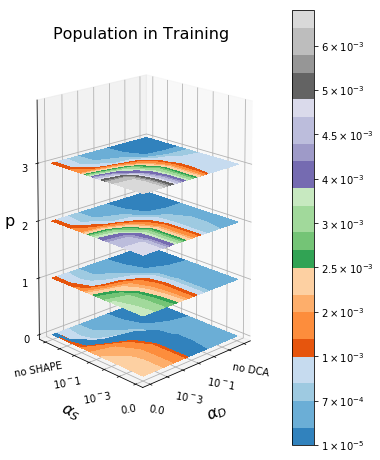

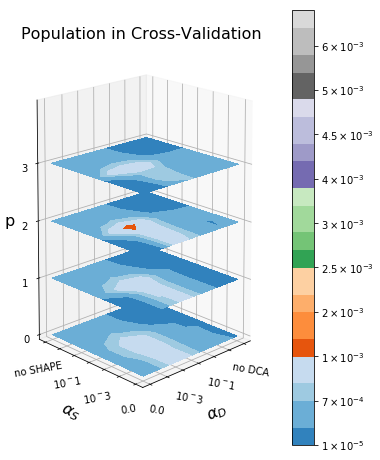

In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
seed = 1998 # 1995 1996 1997 1999 can be selected
RT = 0.61633119654
train = np.zeros((len(set(results.alpha_s.values)),len(set(results.alpha_d.values)),len(set(results.p.values))))
test = train.copy()
vienna = test.copy()
for i,ass in enumerate(np.sort(list(set(results.alpha_s.values)))):
    for j,add in enumerate(np.sort(list(set(results.alpha_d.values)))):
        for k,p in enumerate(np.sort(list(set(results.p.values)))):
            test[i,j,k] = results[(results.seed==1998) & (results.p==p) & (results.alpha_s==ass) & (results.alpha_d==add)].test_cost_average.values[0]
            train[i,j,k] = results[(results.seed==1998) & (results.p==p) & (results.alpha_s==ass) & (results.alpha_d==add)].train_cost_average.values[0]
            vienna[i,j,k] = np.mean(results[(results.seed==1998) & (results.p==p) & (results.alpha_s==ass) & (results.alpha_d==add)].vienna_cost.values)

x = np.log10(np.sort(list(set(results.alpha_s.values))+[10])[:-1]+1e-5)
X, Y = np.meshgrid(x, x)
for (Z,phase) in [(train, 'Training'),(test,'Cross-Validation')]:
    fig = plt.figure(figsize=(6,8))
    ax = fig.gca(projection='3d')
    # Z = train
    #Z = test
    Z = np.exp(-Z/RT)
    levels = np.linspace(np.min(np.exp(-test/RT)), np.max(np.exp(-train/RT)), 50)
    cmap='tab20c'
    ax.contourf(X, Y, 0+.01*Z[:,:,0], zdir='z',levels=0+.01*levels, cmap=cmap)
    ax.contourf(X, Y, 2+.01*Z[:,:,1], zdir='z',levels=2+.01*levels, cmap=cmap)
    ax.contourf(X, Y, 4+.01*Z[:,:,2], zdir='z',levels=4+.01*levels, cmap=cmap)
    ax.contourf(X, Y, 6+.01*Z[:,:,3], zdir='z',levels=6+.01*levels, cmap=cmap)
    ax.view_init(azim=-134,elev=12)
    ax.set_title('Population in '+phase,fontsize=16)
    ax.set_xlabel(r'$ \alpha_{D} $',fontsize=16, labelpad=10)
    ax.set_xticks([-5.00000000e+00, -3.95860731e+00, -2.99567863e+00, -1.99956592e+00,-9.99956573e-01,  4.34292310e-06,  1.00000043e+00])
    ax.set_xticklabels(['0.0','',r'$10^-3$','',r'$10^-1$','','no DCA'],fontsize=10,rotation=-10)
    ax.set_ylabel(r'$ \alpha_{S} $',fontsize=16, labelpad=10)
    ax.set_yticks([-5.00000000e+00, -3.95860731e+00, -2.99567863e+00, -1.99956592e+00,-9.99956573e-01,  4.34292310e-06,  1.00000043e+00])
    ax.set_yticklabels(['0.0','  ',r'$10^-3$','  ',r'$10^-1$','  ','no SHAPE'],fontsize=10,rotation=10)
    ax.set_zlabel('p', rotation='horizontal',fontsize=16)
    ax.set_zticks([0,2,4,6])
    ax.set_zticklabels([0,1,2,3],fontsize=10)
    ax.set_zlim3d(0,8)
    a = plt.contourf(X, Y, .01*Z[:,:,3], zdir='z',levels=levels, cmap=cmap)
    def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
        if exponent is None:
            exponent = int(floor(log10(abs(num))))
        coeff = round(num / float(10**exponent), decimal_digits)
        if precision is None:
            precision = decimal_digits
        return r"${0:.{2}f}\cdot10^{{{1:d}}}$".format(coeff, exponent, precision)
    import matplotlib.colors as cl
    cb = plt.colorbar(a)
    cb.ax.set_yticklabels([r'$1\times 10^{-5}$',r'$7\times 10^{-4}$',r'$1\times 10^{-3}$',r'$2\times 10^{-3}$',r'$2.5\times 10^{-3}$',r'$3\times 10^{-3}$',r'$4\times 10^{-3}$',r'$4.5\times 10^{-3}$',r'$5\times 10^{-3}$',r'$6\times 10^{-3}$'])
plt.show()

### Results

#### Results with selected model

For each dataset splitting, we have a selected model. We go on focusing on results reported in the main text (splitting $S4$ corresponding to 'seed'$=1998$).
Results for different splittings and for different models can be seen by modifying the hyperparameters in the next cell and then running the following cells.

In [21]:
p_min=2        # select a value of p in [0,1,2,3]
ass_min=0.01   # select a value of alpha_S in [inf, 1.0, 0.1, 0.001, 0.0001, 0.0]
add_min=0.001  # select a value of alpha_D in [inf, 1.0, 0.1, 0.001, 0.0001, 0.0]
seed = 1998    # select a value for dataset splitting in [1995,...,1999] corresponding to [S1,...,S5] of the main text

##### DCA channel

In the DCA channel of the network, DCA copulings $J_{ij}$ are mapped to pairing penalties for specific pairs of nucleobases. The composed activation function resulting from the two layers of DCA nodes is: 
\begin{equation}
\lambda_{ij}\left(J_{ij}\right)=C\cdot\sigma\left(A\cdot J_{ij}+B\right)+D
\end{equation}

In the next cell, optimal values of model parameters $\{A,B,C,D\}$ are plotted. To take into account that the function is unchanged is A, B, and C simultaneously change sign we set $A$ as positive.

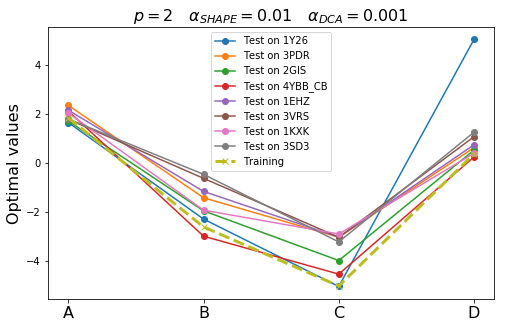

In [22]:
seed = 1998
test_pars = models_tested[(models_tested.seed==seed) & (models_tested.p==p_min) & (models_tested.alpha_s==ass_min) & (models_tested.alpha_d==add_min)]
train_pars = models_trained[(models_trained.seed==seed) & (models_trained.p==p_min) & (models_trained.alpha_s==ass_min) & (models_trained.alpha_d==add_min)]
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5)) 
for i in range(len(test_pars.par_dca.values)):
    if test_pars.par_dca.values[i][0]<=0:
        # fix for invariance when the sign of A,B,C is changed.
        a,b,c=-test_pars.par_dca.values[i][:3]
        d=test_pars.par_dca.values[i][-2]
        plt.plot([a,b,c,d],'o-', label = 'Test on '+test_pars.pdb.values[i])
    else:
        plt.plot(test_pars.par_dca.values[i],'o-', label = 'Test on '+test_pars.pdb.values[i])#,label=test_pars.pdb.values[i])
for i in range(len(train_pars.par_dca.values)):    
      plt.plot(train_pars.par_dca.values[i],'x--',label = 'Training', linewidth=3)
plt.xticks([0,1,2,3],['A','B','C','D'],fontsize=16)
plt.ylabel('Optimal values',fontsize=16)
plt.title(r'$p=$'+str(p_min)+r'$\quad\alpha_{SHAPE}=$'+str(ass_min)+r'$\quad\alpha_{DCA}=$'+str(add_min),fontsize=16)
plt.legend()
plt.show()

In the next cell, we plot the activation function of the DCA channel, using both the set of parameters obtained by training the model on the whole training set, and the sets obtained across iterations of the leave-one-out procedure (one set for each left-out system). 

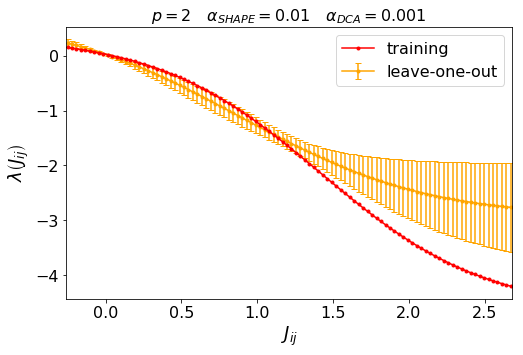

In [23]:
seed=1998
test_pars=models_tested[(models_tested.seed==seed) & (models_tested.p==p_min) & (models_tested.alpha_s==ass_min) & (models_tested.alpha_d==add_min)]
train_pars=models_trained[(models_trained.seed==seed) & (models_trained.p==p_min) & (models_trained.alpha_s==ass_min) & (models_trained.alpha_d==add_min)]
x=np.linspace(np.min(dataset.dca.values[0]),np.max(dataset.dca.values[0]),100)
plt.figure(figsize=(8,5))
def sigmoid_for_plot(x,pp):
    if pp[0]<=0:
        out=-pp[-2]*(1/(1+np.exp(-(-pp[0]*x-pp[1]))))+(pp[-1]+pp[-2])
    else:
        out=pp[-2]*(1/(1+np.exp(-(pp[0]*x+pp[1]))))+pp[-1]
    return out
y=[]
tp = np.zeros((8,4))
tpm = train_pars[train_pars.seed==seed].par_dca.values[0]
for i in range(len(test_pars[test_pars.seed==seed].par_dca.values)):
    tp[i] = test_pars[test_pars.seed==seed].par_dca.values[i]
    y.append(sigmoid_for_plot(x,tp[i]))
yave = np.mean(y,axis=0)
y2ave = np.mean(np.power(y,2),axis=0)
err = np.sqrt(y2ave-np.power(yave,2))
plt.errorbar(x,yave,err,linestyle='-',marker='.',color='orange',barsabove=True,capsize=3,label='leave-one-out')
plt.plot(x,sigmoid_for_plot(x,tpm),linestyle='-',marker='.',color='red',label='training')
plt.xlabel(r'$J_{ij}$',fontsize=18)
plt.ylabel(r'$\lambda\left(J_{ij}\right)$',fontsize=18)
plt.title(r'$p=$'+str(p_min)+r'$\quad\alpha_{SHAPE}=$'+str(ass_min)+r'$\quad\alpha_{DCA}=$'+str(add_min),fontsize=16)
plt.xlim((np.min(x)-0.01,np.max(x)+0.01))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.show()

The different sizes of errorbars, obtained as standard deviations across the leave-one-out procedure, are due to the fact that DCA couplings lying in different regions have different frequency. This can be easily understood by looking at the histogram of DCA couplings in the next cell.

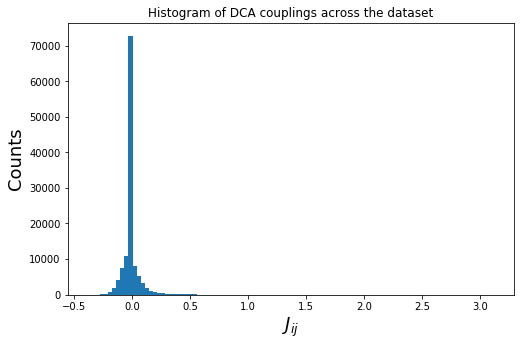

In [24]:
tohist = []
for mol in dataset.pdb.values:
    for i in range(dataset[dataset['pdb']==mol].dca.values[0].shape[0]):
        for j in range(dataset[dataset['pdb']==mol].dca.values[0].shape[1]):
            tohist.append(dataset[dataset['pdb']==mol].dca.values[0][i,j])
plt.figure(figsize=(8,5))
plt.hist(tohist,bins=100)
plt.title('Histogram of DCA couplings across the dataset')
plt.ylabel('Counts',fontsize=18)
plt.xlabel(r'$J_{ij}$',fontsize=18)
plt.show()

##### SHAPE channel

In the SHAPE channel of the network, SHAPE reactivities $R_{i}$ are mapped to pairing penalties for individual nucleobases. The activation function of the single layer of SHAPE nodes is: 
\begin{equation}
\lambda_{i}\left(\vec{R}\right)=\sum\limits_{k=-p}^{+p}a_k\cdot R_{i+k}+b
\end{equation}

In the next cell, optimal values of model paramters $\{\{a_k\}, b\}$, with $p=2$, are plotted.

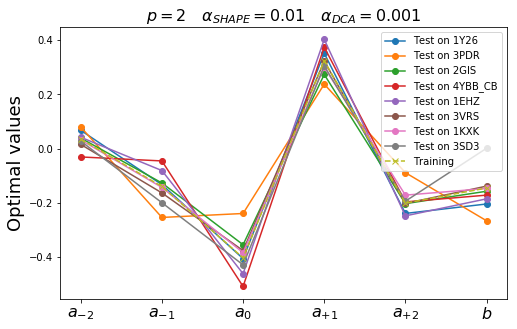

In [25]:
seed=1998
test_pars=models_tested[(models_tested.seed==seed) & (models_tested.p==p_min) & (models_tested.alpha_s==ass_min) & (models_tested.alpha_d==add_min)]
train_pars=models_trained[(models_trained.seed==seed) & (models_trained.p==p_min) & (models_trained.alpha_s==ass_min) & (models_trained.alpha_d==add_min)]
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
for i in range(len(test_pars.par_shape.values)):
      plt.plot(test_pars.par_shape.values[i],'o-', label='Test on '+test_pars.pdb.values[i])#,label=test_pars.pdb.values[i])
for i in range(len(train_pars.par_shape.values)):    
    plt.plot(train_pars.par_shape.values[i],'x--',label='Training')#+str(train_pars.seed.values[i]), linewidth=3)
plt.xticks(range(2*p_min+2),['$a_{-2}$','$a_{-1}$','$a_{0}$','$a_{+1}$','$a_{+2}$'][:len(range(2*p_min+2))]+[r'$b$'],fontsize=16)
plt.ylabel('Optimal values',fontsize=18)
plt.title(r'$p=$'+str(p_min)+r'$\quad\alpha_{SHAPE}=$'+str(ass_min)+r'$\quad\alpha_{DCA}=$'+str(add_min),fontsize=16)
plt.legend()
plt.show()

Optimal values of model parameters for the selected model, across the different dataset splittings

In [26]:
train_pars=models_trained[(models_trained.p==p_min) & (models_trained.alpha_s==ass_min) & (models_trained.alpha_d==add_min)]
test_pars=models_tested[(models_tested.p==p_min) & (models_tested.alpha_s==ass_min) & (models_tested.alpha_d==add_min)]
## Model parameters optimized in the training phase'
train_pars

,seed,p,alpha_s,alpha_d,par_dca,par_shape
102,1995,2,0.01,0.001,"[2.9330516355675864, -0.750382363633191, -2.91...","[0.21954752392727334, 0.05808986855699271, -0...."
298,1996,2,0.01,0.001,"[3.0082235686112373, -0.8360466703349521, -3.5...","[0.41319979687929487, 0.021285428809068925, -0..."
494,1997,2,0.01,0.001,"[-2.8011006694486387, 1.9705783062623203, 2.22...","[0.08192323208773981, -0.11286483323705217, -0..."
690,1998,2,0.01,0.001,"[1.8410949391710525, -2.6132398833033483, -5.0...","[0.03453233546423258, -0.14003890493341867, -0..."
886,1999,2,0.01,0.001,"[1.4427123582431953, -0.20452890579378774, -4....","[0.1554079723481324, -0.05697255740171898, -0...."


In [27]:
## Model parameters optimized in the leave-one-out, a set for each left-out system')
test_pars

,seed,p,alpha_s,alpha_d,pdb,par_dca,par_shape
816,1995,2,0.01,0.001,1EHZ,"[-3.6895414320027675, 0.8846820531920929, 2.98...","[0.43504282334314576, 0.020904060646795068, -0..."
817,1995,2,0.01,0.001,4YBB_CB,"[2.7535584907658004, -0.6880970665980601, -2.9...","[0.27548053715835075, 0.045047827967405675, -0..."
818,1995,2,0.01,0.001,3DIG,"[2.8975077547600145, -0.7427734583054779, -3.1...","[0.06476499786941854, -0.16254240630400188, -0..."
819,1995,2,0.01,0.001,1KXK,"[2.853687895435222, -1.0017032025392891, -2.86...","[0.2204287379240965, 0.0639760899291347, -0.48..."
820,1995,2,0.01,0.001,2GDI,"[-1.541522316981129, 0.2630716626352833, 4.030...","[0.4224943222561744, -0.2153840113000524, -0.2..."
821,1995,2,0.01,0.001,3IRW,"[10.58355332096351, -4.164165836282508, -2.240...","[0.16704547940646927, 0.10947307875776605, -0...."
822,1995,2,0.01,0.001,1Y26,"[2.8200337940394444, -0.7333739984523728, -3.0...","[0.3152066532256862, -0.0754925864859909, -0.4..."
823,1995,2,0.01,0.001,2GIS,"[-6.49146023693622, 1.902032418450708, 1.84848...","[0.29663670002086245, -0.06383141819825067, -0..."
2384,1996,2,0.01,0.001,2GIS,"[-3.454249591337141, 1.4905838987071205, 3.584...","[0.4100829174289935, 0.03822566028912147, -0.4..."
2385,1996,2,0.01,0.001,3IRW,"[-9.835014778869338, 3.590159311466491, 2.6068...","[0.372140871461506, 0.09124914773943907, -0.48..."


Here we define useful constants, a function to map the cost function to population of native structure, and the network functions mapping data to penalties alogn with those used to compute the cost function related to native structures and accuracy of MFE predictions.
Notice that the latter functions are the same used in the script for model optimization 'model_optimize.py'

In [28]:
import re

RT=0.61633119654

def population(costf):
    pop = np.exp(-costf/RT)
    return pop

def lin(x):
    out=x
    dev=1.0
    return [out,dev]

def sigmoid(x):
    out=1/(1+np.exp(-x))
    dev=np.exp(-x)/((1+np.exp(-x))**2)
    return [out,dev]

def dca(coup,par):
    act=sigmoid(par[0]*coup+par[1])
    dev=np.zeros((len(par),coup.shape[0],coup.shape[1]))
    out=par[2]*act[0]+par[3]
    dev[0,:,:]=par[2]*act[1]*coup
    dev[1,:,:]=par[2]*act[1]
    dev[2,:,:]=act[0]
    dev[3,:,:]=1.0
    return [out,dev]

def loop(shape,seq,index,par,window):
    out=0.0
    dev=np.zeros(len(par))
    nn_left=-window
    nn_right=-nn_left+1
    width=len(range(nn_left,nn_right))+1
    x=np.zeros(width)
    if index < -nn_left:
        nn_left=-index
    if index >= len(shape)+nn_left:
        nn_right=len(shape)-index
    x[nn_left + window: nn_right + window]= shape[index+nn_left:index+nn_right]
    x[-1]=1.0
    activation=lin(np.dot(par[:width],x))
    out=activation[0]
    for i in range(len(dev)):
        dev[i]=activation[1]*x[i]
    return [out, dev]

def cost(p,par_shape,par_dca,ass,add,mol):
    seq = dataset[dataset.pdb==mol].seq.values[0]
    fold = rna.fold_compound(seq)
    R = dataset[dataset.pdb==mol].norm_r.values[0]
    stru = dataset[dataset.pdb==mol].stru.values[0]
    dcamx = dataset[dataset.pdb==mol].dca.values[0]
    psen_dca=dca(dcamx,par_dca)
    if np.isinf(add)==False:
            for i in range(len(seq)):
                for j in range(i+4,len(seq)):
                    fold.sc_add_bp(i+1,j+1,RT*psen_dca[0][i,j])
    if np.isinf(ass)==False:
        for i in range(len(R)):
            psen_shape=loop(R,seq,i,par_shape,p)
            fold.sc_add_up(i+1,RT*psen_shape[0])
    part = fold.pf()[1]
    ene = fold.eval_structure(stru)
    cost = ene-part
    return cost

def db2matrix(db):
    """Convert dot-bracked to 1/0 matrix"""
    matrix=np.zeros((len(db),len(db)))
    more=True
    while more:
        more=False
        for x in re.finditer("\([^()]*\)",db):
            more=True
            matrix[x.start(),x.end()-1]=1
            matrix[x.end()-1,x.start()]=1
            db=db[0:x.start()] + "." + db[x.start()+1:x.end()-1] + "." + db[x.end():]
    return matrix

def accuracy(p,par_shape,par_dca,ass,add,mol):
    seq = dataset[dataset.pdb==mol].seq.values[0]
    fold = rna.fold_compound(seq)
    R = dataset[dataset.pdb==mol].norm_r.values[0]
    stru = dataset[dataset.pdb==mol].stru.values[0]
    refmx = db2matrix(stru)
    dcamx = dataset[dataset.pdb==mol].dca.values[0]
    psen_dca=dca(dcamx,par_dca)
    if np.isinf(add)==False:
            for i in range(len(seq)):
                for j in range(i+4,len(seq)):
                    fold.sc_add_bp(i+1,j+1,RT*psen_dca[0][i,j])
    if np.isinf(ass)==False:
        for i in range(len(R)):
            psen_shape=loop(R,seq,i,par_shape,p)
            fold.sc_add_up(i+1,RT*psen_shape[0])
    mfe = fold.mfe()[0]
    mfemx = db2matrix(mfe)
    tp = 0
    fp = 0
    fn = 0
    for i in range(refmx.shape[0]):
        for j in range(i,refmx.shape[1]):
            if refmx[i,j]==mfemx[i,j] and refmx[i,j]==1:
                tp += 1
            elif refmx[i,j]!=mfemx[i,j]:
                if refmx[i,j]==0:
                    fp += 1
                else:
                    fn += 1
    ppv = 1/(1+(fp/tp))
    sens = 1/(1+(fn/tp))
    mcc = np.sqrt(ppv*sens)
    return [tp,fp,fn,ppv,sens,mcc]

#### Populations and MFE predictions in the training set

In [29]:
seed=1998
train_dca = train_pars.par_dca.values[0]
train_shape = train_pars.par_shape.values[0]

train = results[(results.seed==seed) & (results.p==p_min) 
        & (results.alpha_s==ass_min) & (results.alpha_d==add_min)].copy()
train['train_mcc'] = 0.0
train['train_pop'] = 0.0
train['vienna_pop'] = 0.0
for m,mol in enumerate(train.pdb.values):
    train.at[train[train.pdb==mol].index.values[0], 'vienna_mcc'] = accuracy(p = 0 ,par_shape = train_shape,par_dca = train_dca,ass = np.inf,add = np.inf, mol = mol)[-1]
    train.at[train[train.pdb==mol].index.values[0], 'train_mcc'] = accuracy(p = p_min ,par_shape = train_shape,par_dca = train_dca,ass = ass_min,add = add_min, mol = mol)[-1]
    train.at[train[train.pdb==mol].index.values[0], 'train_pop'] = population(train[train.pdb==mol].train_cost)
    train.at[train[train.pdb==mol].index.values[0], 'vienna_pop'] = population(train[train.pdb==mol].vienna_cost)
train.drop(columns=['vienna_cost', 'train_cost','test_cost', 'test_cost_average','test_cost_average', 'train_cost_average'])

,pdb,seed,p,alpha_s,alpha_d,train_mcc,train_pop,vienna_pop,vienna_mcc
5520,1EHZ,1998,2,0.01,0.001,0.953463,0.000139,4.357289e-05,0.975900
5521,1KXK,1998,2,0.01,0.001,0.869565,0.000065,5.138101e-07,0.808694
5522,1Y26,1998,2,0.01,0.001,0.977008,0.000012,1.957361e-06,0.977008
5523,2GIS,1998,2,0.01,0.001,0.962963,0.014835,7.702716e-06,0.943564
5524,3PDR,1998,2,0.01,0.001,0.792429,0.457297,6.256960e-03,0.792429
5525,3SD3,1998,2,0.01,0.001,0.831522,0.291388,2.807112e-03,0.705642
5526,3VRS,1998,2,0.01,0.001,1.000000,0.026972,1.225844e-02,0.435194
5527,4YBB_CB,1998,2,0.01,0.001,0.869626,0.000232,2.009110e-06,0.257172


#### Populations and MFE predictions in the leave-one-out

In [30]:
test_dca = test_pars.par_dca.values[0]
test_shape = test_pars.par_shape.values[0]

test = results[(results.seed==seed) & (results.p==p_min) 
        & (results.alpha_s==ass_min) & (results.alpha_d==add_min)].copy()
test['test_mcc'] = 0.0
test['test_pop'] = 0.0
test['vienna_pop'] = 0.0
for m,mol in enumerate(test.pdb.values):
    test_dca = test_pars.par_dca.values[m]
    test_shape = test_pars.par_shape.values[m]
    test.at[test[test.pdb==mol].index.values[0], 'vienna_mcc'] = accuracy(p = 0 ,par_shape = test_shape,par_dca = test_dca,ass = np.inf,add = np.inf, mol = mol)[-1]
    test.at[test[test.pdb==mol].index.values[0], 'test_mcc'] = accuracy(p = p_min ,par_shape = test_shape,par_dca = test_dca,ass = ass_min,add = add_min, mol = mol)[-1]
    test.at[train[train.pdb==mol].index.values[0], 'test_pop'] = population(test[test.pdb==mol].test_cost)
    test.at[train[train.pdb==mol].index.values[0], 'vienna_pop'] = population(test[test.pdb==mol].vienna_cost)    
test.drop(columns=['vienna_cost', 'train_cost', 'test_cost','train_cost_average','test_cost_average'])

,pdb,seed,p,alpha_s,alpha_d,test_mcc,test_pop,vienna_pop,vienna_mcc
5520,1EHZ,1998,2,0.01,0.001,0.953463,0.000127,4.357289e-05,0.975900
5521,1KXK,1998,2,0.01,0.001,0.851257,0.000018,5.138101e-07,0.808694
5522,1Y26,1998,2,0.01,0.001,0.977008,0.000012,1.957361e-06,0.977008
5523,2GIS,1998,2,0.01,0.001,0.962963,0.009753,7.702716e-06,0.943564
5524,3PDR,1998,2,0.01,0.001,0.792429,0.325432,6.256960e-03,0.792429
5525,3SD3,1998,2,0.01,0.001,0.831522,0.180664,2.807112e-03,0.705642
5526,3VRS,1998,2,0.01,0.001,1.000000,0.026277,1.225844e-02,0.435194
5527,4YBB_CB,1998,2,0.01,0.001,0.958994,0.000042,2.009110e-06,0.257172


#### Populations and MFE predictions in the validation set

In [31]:
train_dca = train_pars[train_pars.seed==seed].par_dca.values[0]
train_shape = train_pars[train_pars.seed==seed].par_shape.values[0]
validation = pd.DataFrame(columns=['pdb','seed','p','alpha_s','alpha_d','vienna_pop','vienna_mcc','validation_pop','validation_mcc'])
for mol in dataset.pdb.values:
    if mol not in results[(results.seed==seed) & (results.p==p_min) 
        & (results.alpha_s==ass_min) & (results.alpha_d==add_min)].pdb.values:
        vienna_pop=validation_pop=None
        vienna_pop = population(cost(p = 0 ,par_shape = train_shape,par_dca = train_dca,ass = np.inf,add = np.inf, mol = mol))
        vienna_mcc = accuracy(p = 0 ,par_shape = train_shape,par_dca = train_dca,ass = np.inf,add = np.inf, mol = mol)[-1]
        validation_pop = population(cost(p = p_min ,par_shape = train_shape,par_dca = train_dca,ass = ass_min,add = add_min, mol = mol))
        validation_mcc = accuracy(p = p_min ,par_shape = train_shape,par_dca = train_dca,ass = ass_min,add = add_min, mol = mol)[-1]
        validation = validation.append({'pdb': mol, 'seed': seed, 'p': p_min, 'alpha_s': ass_min, 'alpha_d': add_min, 'vienna_pop': vienna_pop, 'vienna_mcc': vienna_mcc, 'validation_pop': validation_pop, 'validation_mcc': validation_mcc}, ignore_index=True)
validation

,pdb,seed,p,alpha_s,alpha_d,vienna_pop,vienna_mcc,validation_pop,validation_mcc
0,2GDI,1998,2,0.01,0.001,2.219025e-07,0.810443,0.000058,0.831497
1,3DIG,1998,2,0.01,0.001,5.641180e-05,0.902690,0.000024,0.946580
2,3IRW,1998,2,0.01,0.001,1.312660e-06,0.255377,0.000006,0.870388


#### Populations and MFE predictions in the validation set for all dataset splittings

In [32]:
validation = pd.DataFrame(columns=['pdb','seed','p','alpha_s','alpha_d','vienna_pop','vienna_mcc','validation_pop','validation_mcc'])
for seed in range(1995,2000):
    train_dca = train_pars[train_pars.seed==seed].par_dca.values[0]
    train_shape = train_pars[train_pars.seed==seed].par_shape.values[0]
#     validation = pd.DataFrame(columns=['pdb','seed','p','alpha_s','alpha_d','vienna_pop','vienna_mcc','validation_pop','validation_mcc'])
    for mol in dataset.pdb.values:
        if mol not in results[(results.seed==seed) & (results.p==p_min) 
            & (results.alpha_s==ass_min) & (results.alpha_d==add_min)].pdb.values:
            vienna_pop=validation_pop=None
            vienna_pop = population(cost(p = 0 ,par_shape = train_shape,par_dca = train_dca,ass = np.inf,add = np.inf, mol = mol))
            vienna_mcc = accuracy(p = 0 ,par_shape = train_shape,par_dca = train_dca,ass = np.inf,add = np.inf, mol = mol)[-1]
            validation_pop = population(cost(p = p_min ,par_shape = train_shape,par_dca = train_dca,ass = ass_min,add = add_min, mol = mol))
            validation_mcc = accuracy(p = p_min ,par_shape = train_shape,par_dca = train_dca,ass = ass_min,add = add_min, mol = mol)[-1]
            validation = validation.append({'pdb': mol, 'seed': seed, 'p': p_min, 'alpha_s': ass_min, 'alpha_d': add_min, 'vienna_pop': vienna_pop, 'vienna_mcc': vienna_mcc, 'validation_pop': validation_pop, 'validation_mcc': validation_mcc}, ignore_index=True)
validation

,pdb,seed,p,alpha_s,alpha_d,vienna_pop,vienna_mcc,validation_pop,validation_mcc
0,3PDR,1995,2,0.01,0.001,5.138098e-07,0.792429,0.000020,0.792429
1,3SD3,1995,2,0.01,0.001,2.009110e-06,0.705642,0.000019,0.831522
2,3VRS,1995,2,0.01,0.001,2.807112e-03,0.435194,0.204058,1.000000
3,1EHZ,1996,2,0.01,0.001,6.256958e-03,0.975900,0.003144,0.953463
4,3PDR,1996,2,0.01,0.001,5.138098e-07,0.792429,0.000003,0.792429
5,3SD3,1996,2,0.01,0.001,2.009110e-06,0.705642,0.000027,0.831522
6,2GDI,1997,2,0.01,0.001,2.219025e-07,0.810443,0.000046,0.810443
7,2GIS,1997,2,0.01,0.001,1.957362e-06,0.943564,0.000012,0.962963
8,3DIG,1997,2,0.01,0.001,5.641180e-05,0.902690,0.000059,0.946580
9,2GDI,1998,2,0.01,0.001,2.219025e-07,0.810443,0.000058,0.831497


## MFE predictions with partial data
We report here the predicted MFE secondary structures for systems in the validation set, using the selected model including only DCA data and the selected model including only SHAPE data, for the dataset splitting S4 (seed=1998, presented in main text). All the secondary structure diagrams are drown with FORNA (http://rna.tbi.univie.ac.at/forna/).

In [33]:
from IPython.display import Image

### 2GDI

#### DCA only
$\alpha_S=\infty,\quad \alpha_D=0.0001$

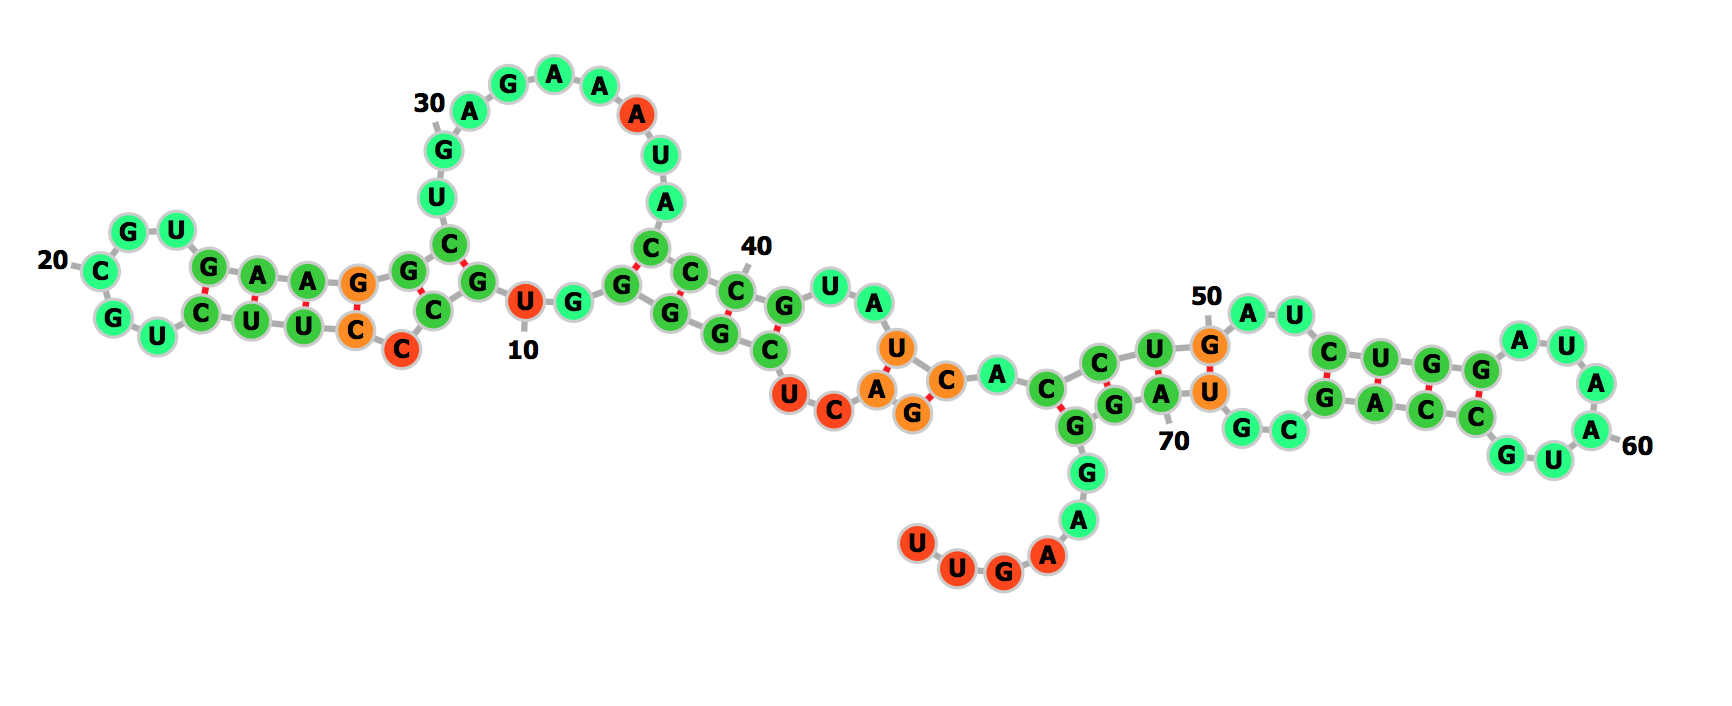

In [34]:
Image("2GDI_inf_0.0001_0.png", width='500')

#### SHAPE only
$\alpha_S=0.01,\quad \alpha_D=\infty,\quad p=3$

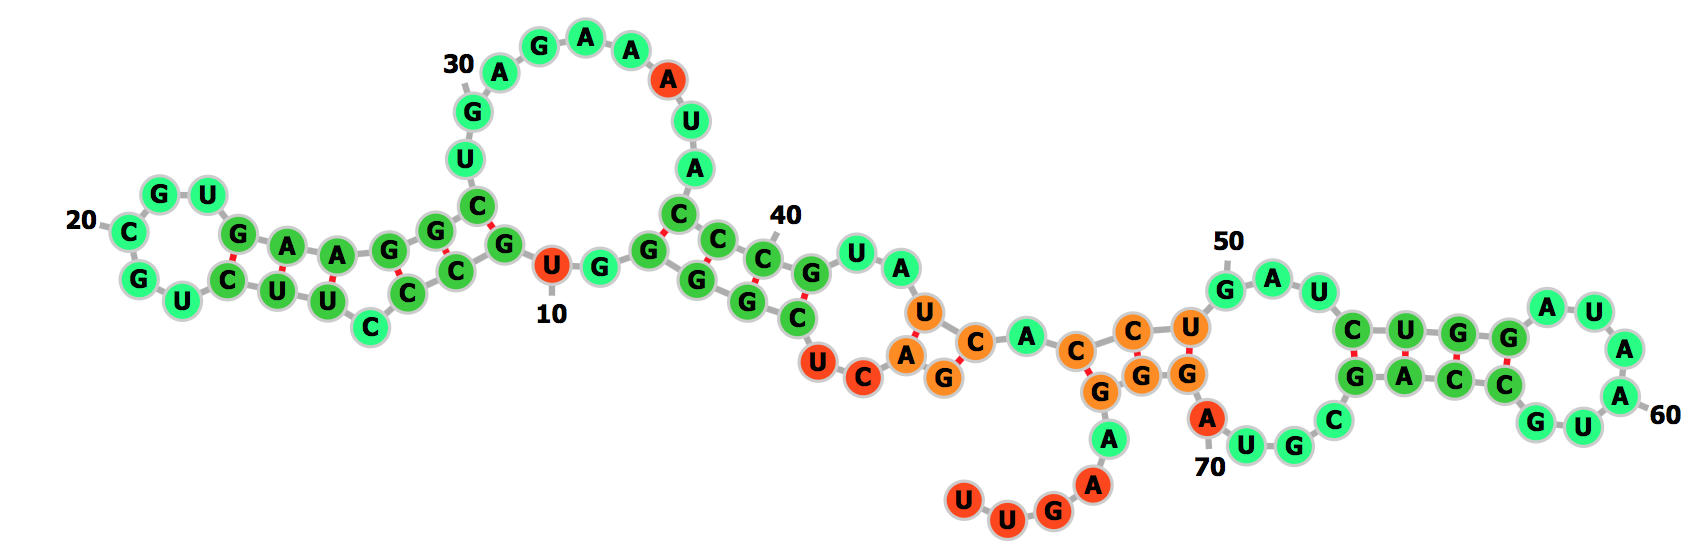

In [35]:
Image("2GDI_0.01_inf_3.png", width='500')

### 3DIG

#### DCA only
$\alpha_S=\infty,\quad \alpha_D=0.0001$

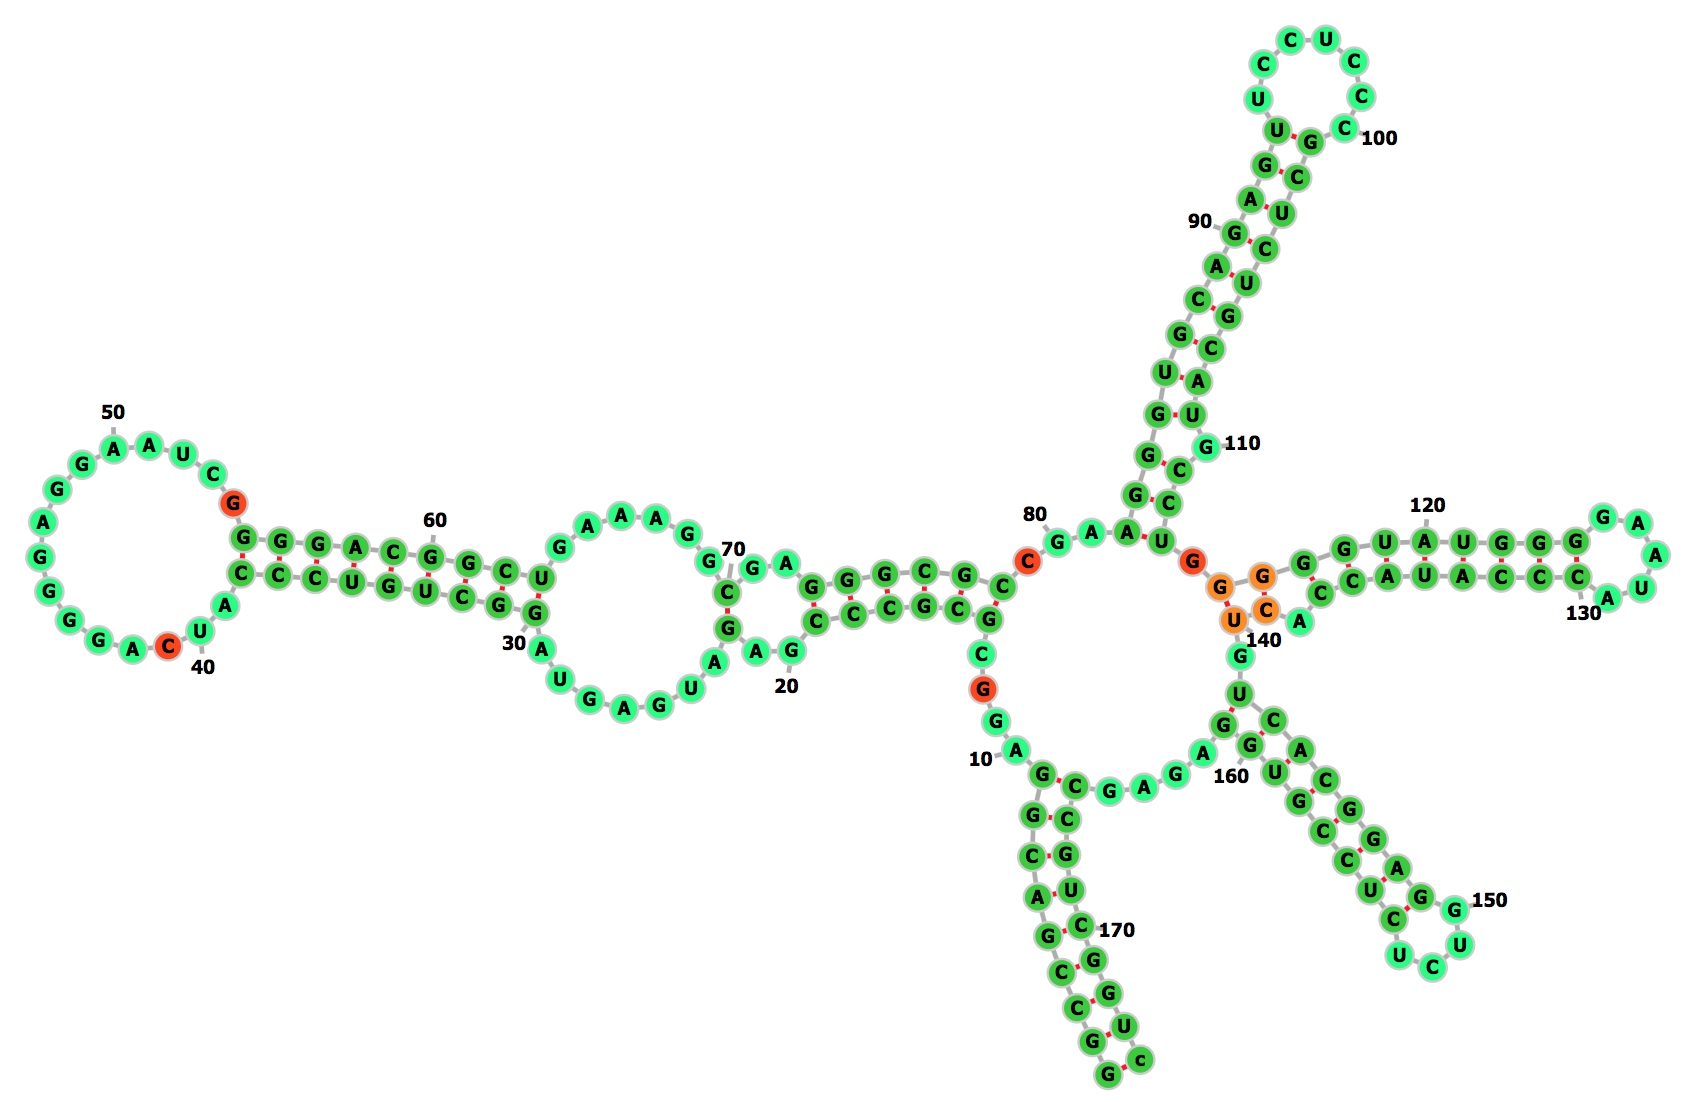

In [36]:
Image("3DIG_inf_0.0001_0.png", width='500')

#### SHAPE only
$\alpha_S=0.01,\quad \alpha_D=\infty,\quad p=3$

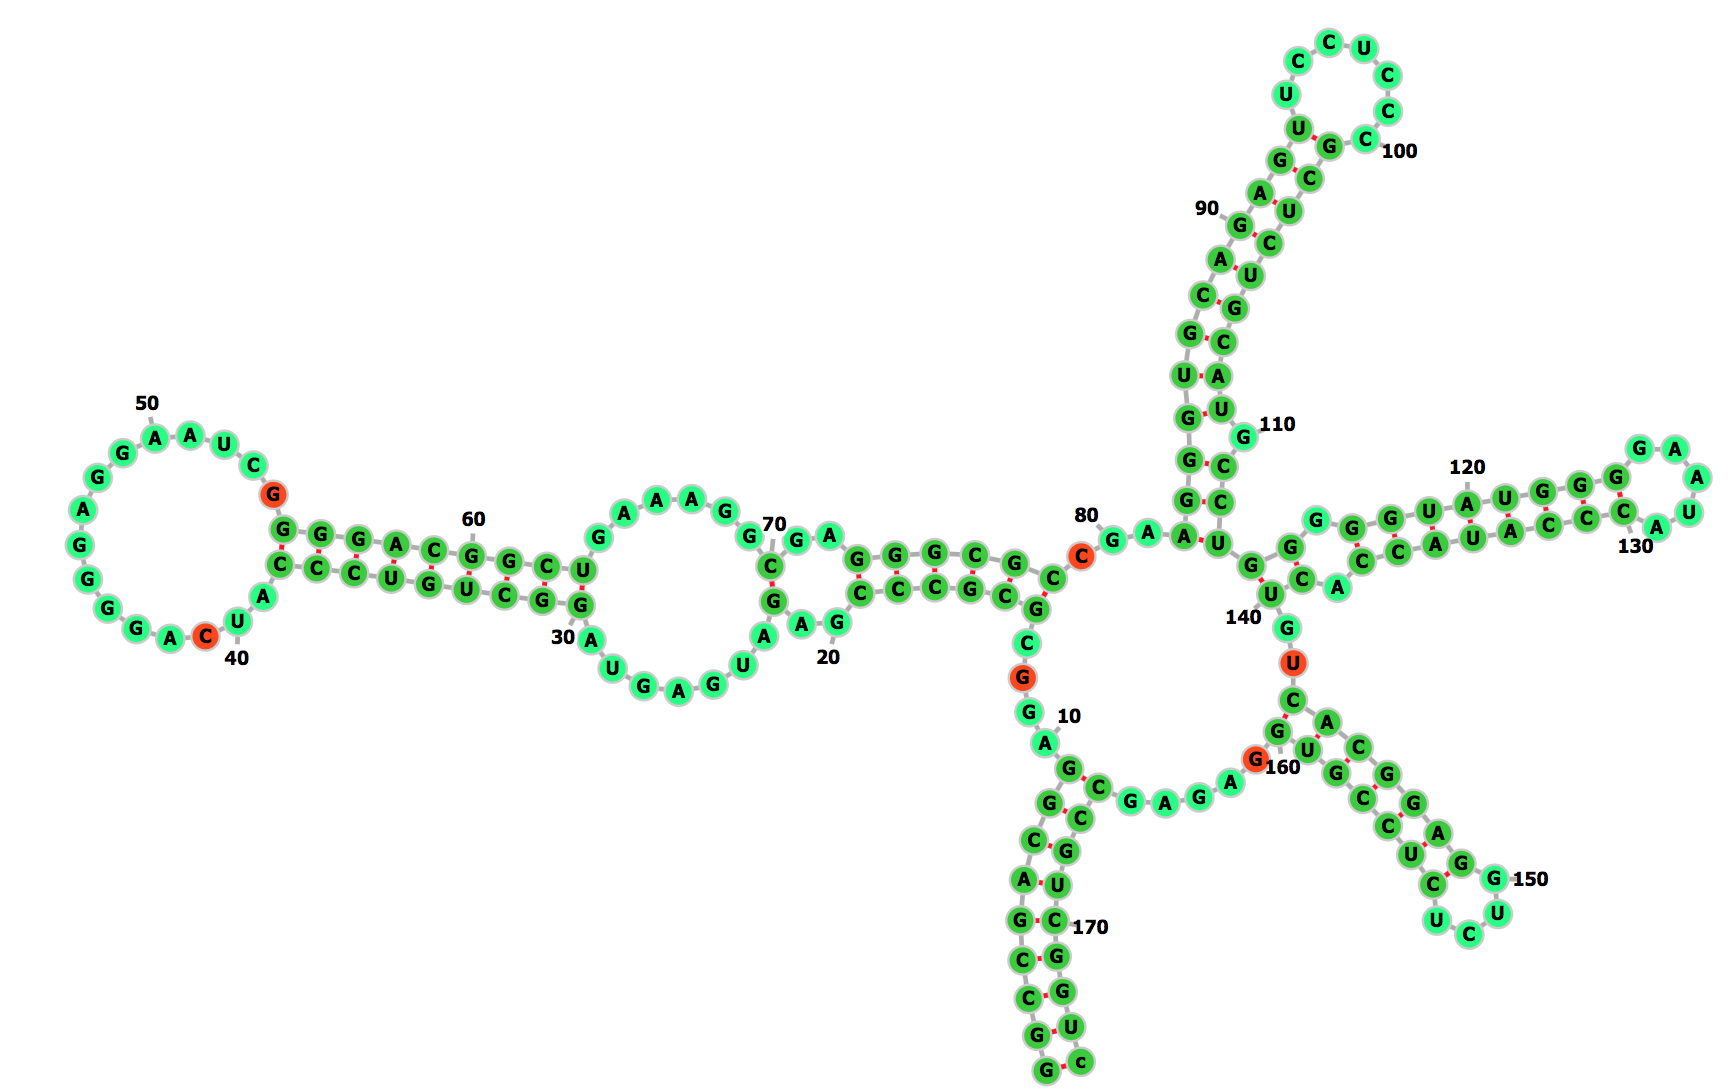

In [37]:
Image("3DIG_0.01_inf_3.png", width='500')

### 3IRW

#### DCA only
$\alpha_S=\infty,\quad \alpha_D=0.0001$

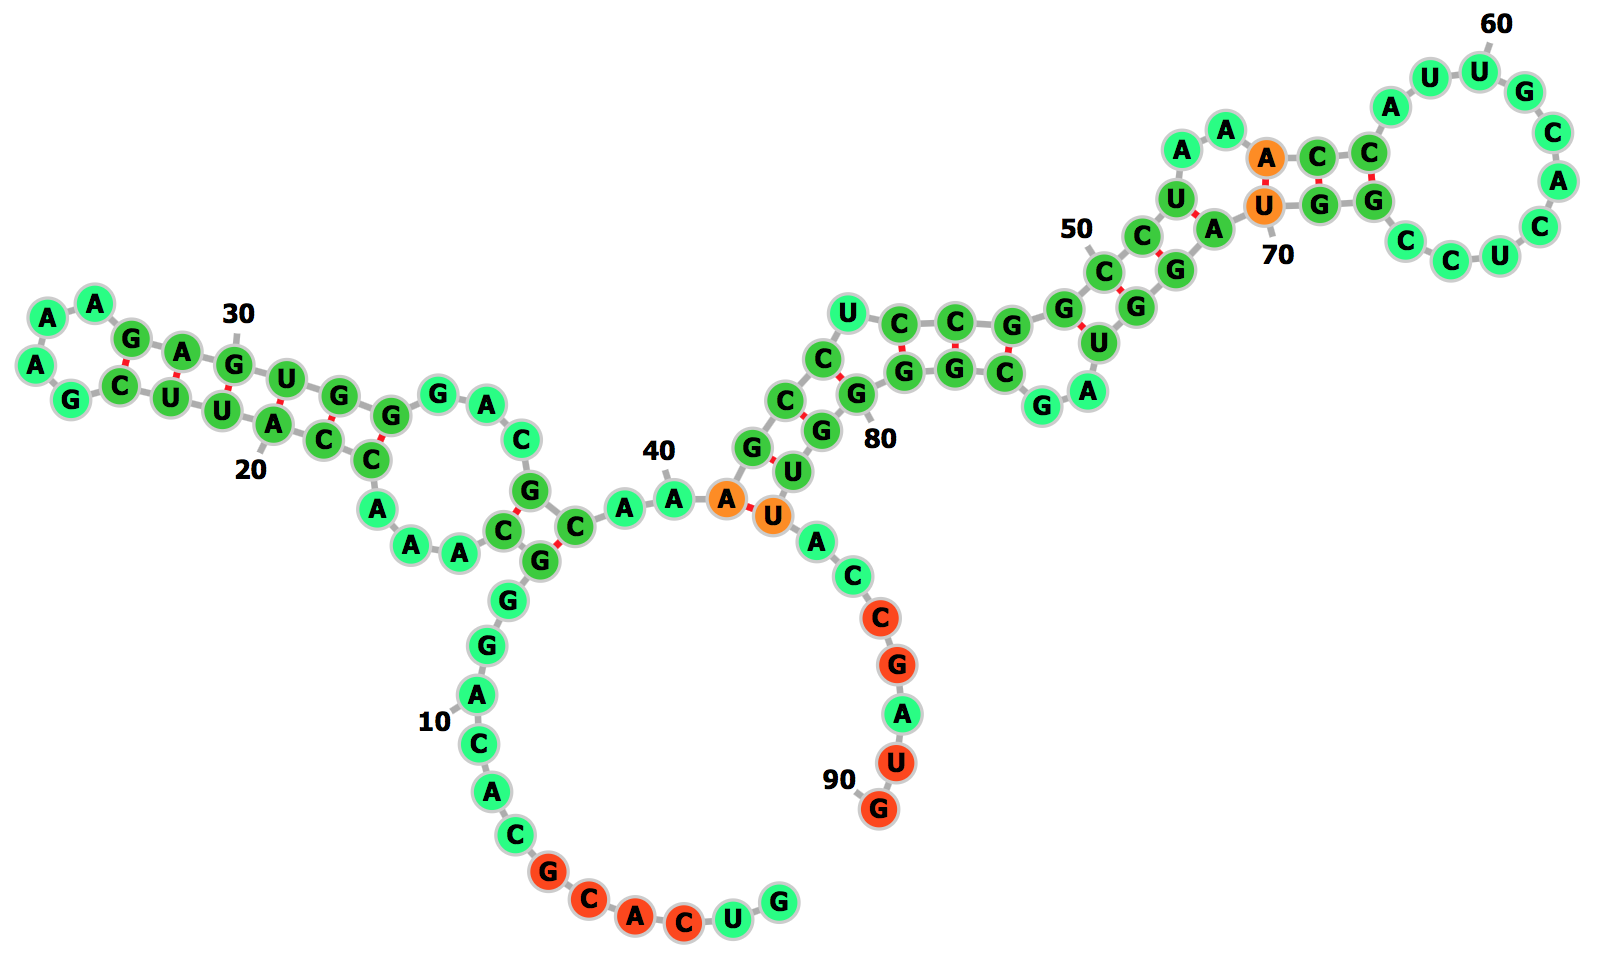

In [38]:
Image("3IRW_inf_0.0001_0.png", width='500')

#### SHAPE only
$\alpha_S=0.01,\quad \alpha_D=\infty,\quad p=3$

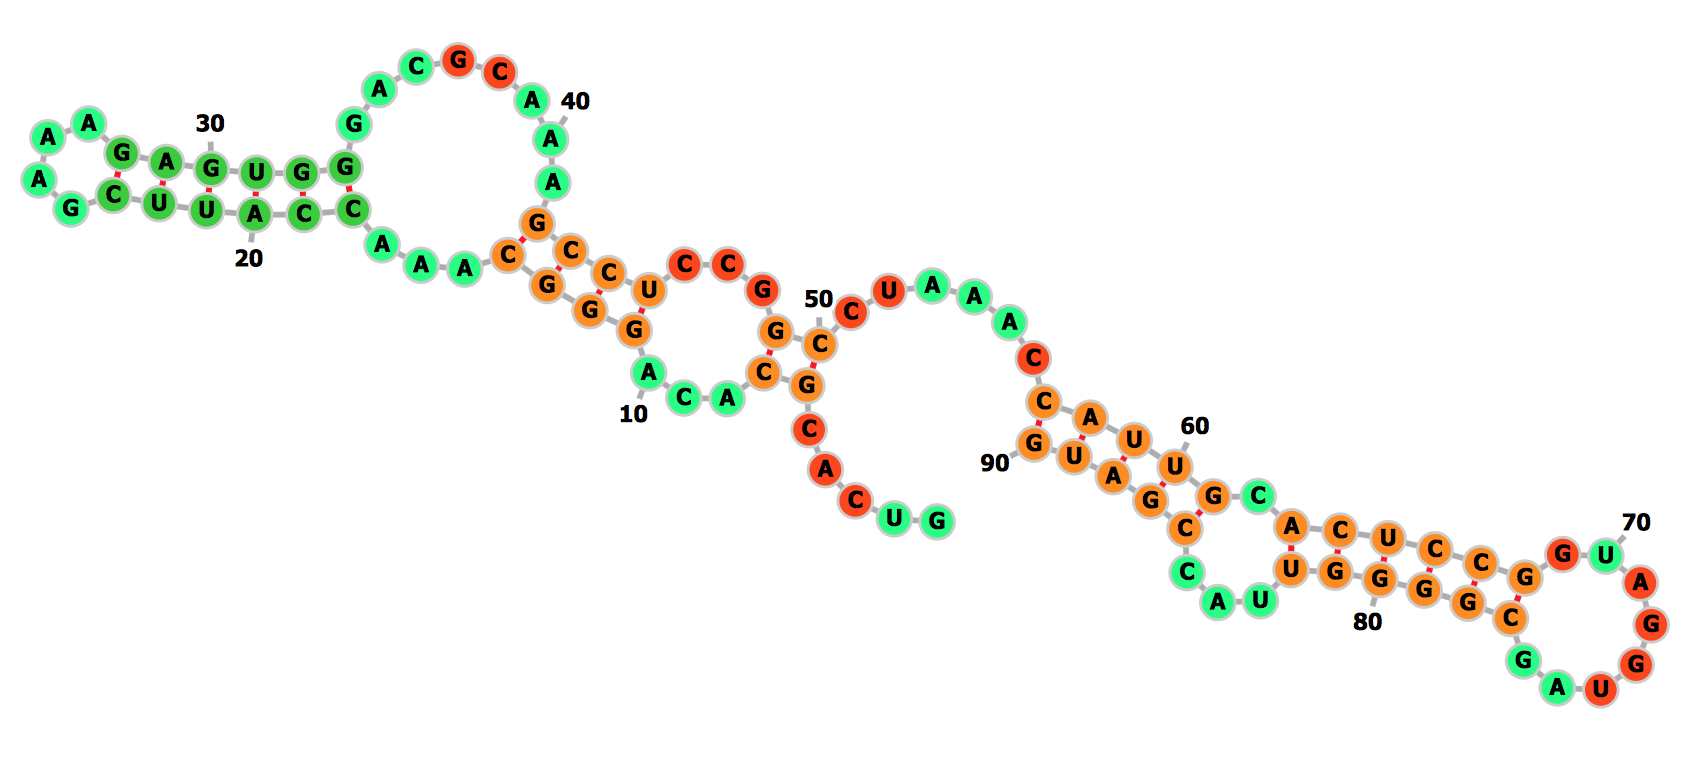

In [39]:
Image("3IRW_0.01_inf_3.png", width='500')